#Import and Data Clean

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installing the ta library

> This library has the technical indicators which we inlcude in our study.



In [ ]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the libraries

In [ ]:
import os
import numpy as np
import ta
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
nltk.download('vader_lexicon')
import shutil
from joblib import dump, load

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


1. Reference for Sentiment Analyzer: https://www.nltk.org/howto/sentiment.html
2. Reference for TA Library: https://github.com/bukosabino/ta

In [ ]:
def get_tech_ind(data):

    # Adding Simple Moving Average
    data['MA7'] = ta.trend.sma_indicator(close = data.iloc[:,6], window = 7)
    data['MA20'] = ta.trend.sma_indicator(close = data.iloc[:,6], window = 20)
    
    # Adding MACD
    data['MACD'] = ta.trend.macd(close = data.iloc[:,6])

    # Adding Rate of Change
    data['ROC'] = ta.momentum.roc(close = data.iloc[:,6], window = 12)

    # Adding Exponential Moving Average
    data['EMA'] = ta.trend.ema_indicator(close = data.iloc[:,6])

    # Adding Bollinger Bands
    data['Bollinger_Bands'] = ta.volatility.BollingerBands(close = data.iloc[:,6]).bollinger_mavg()

    # Adding LogMomentum
    data['Log_Momentum'] = np.log(data.iloc[:,6]-1)

    return data

In [ ]:
def clean_data(tweet_data, stock_data, stock_name):
  stock_name = stock_name
  df = tweet_data[tweet_data['Stock Name'] == stock_name] #obtaining dataset for a particular stock name

  sent_df = df.copy()
  sent_df["sentiment_score"] = '' #adding a column for sentiment score in the dataframe
  sent_df["Negative"] = '' #adding a column for indicating negative sentiment score in the dataframe
  sent_df["Neutral"] = '' #adding a column for indicating the neutral sentiment score in the dataframe
  sent_df["Positive"] = '' #adding a column for indicating the positive sentiment score in the dataframe

  %time
  sentiment_analyzer = SentimentIntensityAnalyzer()
  for indx, row in sent_df.T.iteritems():
      try:
          sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'Tweet'])
          sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
          sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
          sent_df.at[indx, 'Negative'] = sentence_sentiment['neg'] #obtaining the negative component of sentiment score
          sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu'] #obtaining the neutral component of sentiment score
          sent_df.at[indx, 'Positive'] = sentence_sentiment['pos'] #obtaining the positive component of sentiment score
      except TypeError:
          print (sent_df.loc[indx, 'Tweet'])
          print (indx)
          break

  sent_df['Date'] = pd.to_datetime(sent_df['Date'])
  sent_df['Date'] = sent_df['Date'].dt.date
  sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Company Name'])
  twitter_df = sent_df.groupby(['Date']).mean() #getting the mean sentiment score for a day as there are multiple tweets on a single day

  twitter_df = twitter_df.reset_index()

  all_stocks['Date'] = pd.to_datetime(all_stocks['Date'])
  all_stocks['Date'] = all_stocks['Date'].dt.date

  stock_df = all_stocks[all_stocks['Stock Name'] == stock_name] #subsetting the dataset for particular stock
  final_df = stock_df.merge(twitter_df, on = ['Date'], how = 'left') #merging the dataset having sentiment score with the dataset having financial information
  final_df = final_df.loc[:,['Date', 'Stock Name', 'sentiment_score', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] #correcting the ordering of columns in the dataframe
  final_df.reset_index(inplace = True, drop = True)

  cols = 0
  rows = 0 

  fig, ax = plt.subplots(1, 1, figsize = (20,8), tight_layout = True)

# Plotting the Closing Price of the stock
  for tic in list(final_df['Stock Name'].unique()):
      ax.plot(final_df.loc[final_df['Stock Name'] == tic, 'Date'] ,final_df.loc[final_df['Stock Name'] == tic,'Close'], color='#008B8B')
      ax.set(xlabel='Date', ylabel='USD', title=f'{tic} Stock Price')
      ax.xaxis.set_major_formatter(DateFormatter('%Y'))

  plt.show()

  
  tech_df = pd.DataFrame()

  df_1 = final_df[final_df['Stock Name'] == stock_name]
  df_2 = get_tech_ind(df_1) #obtaining the technical indicators for the dataset
  df_2 = df_2.iloc[25:,].reset_index(drop=True)
  tech_df = pd.concat([tech_df,df_2], axis = 0)

  tech_df.iloc[:, 1:] = pd.concat([tech_df.iloc[:, 1:].ffill()]) #using the forward filling function to fill missing values
  
  cols = 0
  rows = 0 

  fig, ax = plt.subplots(1, 1, figsize = (20,8), tight_layout = True);

# Plotting graph for technical indicators
  for tic in list(tech_df['Stock Name'].unique()):
    
      ax.plot(tech_df.loc[tech_df['Stock Name'] == tic, 'Date'] ,tech_df.loc[tech_df['Stock Name'] == tic,'MA7'], color='g', linestyle='--', label='Moving Average (7 days)');
      ax.plot(tech_df.loc[tech_df['Stock Name'] == tic, 'Date'] ,tech_df.loc[tech_df['Stock Name'] == tic,'Close'], color='#6A5ACD', label='Closing Price');
      ax.plot(tech_df.loc[tech_df['Stock Name'] == tic, 'Date'] ,tech_df.loc[tech_df['Stock Name'] == tic,'MA20'], color='r', linestyle='-.', label='Moving Average (20 days)');
      ax.set(xlabel='Date', ylabel='USD', title=f'{tic} Technical Indicators');
      ax.xaxis.set_major_formatter(DateFormatter('%Y'));
      ax.legend();


  plt.show();

  tech_df = tech_df.drop(['Stock Name'], axis = 1)
  date_col = tech_df['Date']
  tech_df = tech_df.set_index('Date')
  tech_df = tech_df.sort_values('Date')
  tech_df.reset_index(inplace=True,drop=True)

  X = tech_df.drop(['Adj Close'], axis = 1) #obtaining the dataset with predictors
  y = pd.DataFrame(tech_df['Adj Close']) #obtaining the target variable for predicition

  return X, y, date_col


x_y_predictions splits the dataset in M:N split defined in the report. We use previous 4 days for predicting the price of 1 day ahead.

In [ ]:
def x_y_predictions(x_data, y_data):
    X_data = []
    Y_data = []
    YC_data = []

    for i in range(0,len(x_data),1):
      X = x_data[i: i + days_to_consider][:,:] #obtaining 4 days of consecutive windows of predictors
      y = y_data[i + days_to_consider : i + days_to_consider + days_to_predict][:,0] #obtaining the batches of target variable being predicted
      yc = y_data[i: i + days_to_consider][:,:] #obtainining 4 days of consecutive windows of closing prices
      if len(X) == days_to_consider and len(y) == days_to_predict:
        X_data.append(X)
        Y_data.append(y)
        YC_data.append(yc)

    return np.array(X_data), np.array(Y_data), np.array(YC_data)

In [ ]:
def split_train_test(data):
    train_size = round(len(data) * 0.85) 
    data_train = data[0:train_size] #obtaining 85% for training
    data_test = data[train_size:] #obtaining 15% for testing 
    return data_train, data_test

In [ ]:
def data_preprocess(X, y, days, predict):
  X_scaler = MinMaxScaler() #scaling the feature dataset
  y_scaler = MinMaxScaler() #scaling the target variable
  X_scaled_df = X_scaler.fit_transform(X)
  y_scaled_df = y_scaler.fit_transform(y)

  dump(X_scaler, 'X_scaler.joblib') #saving the scalar
  dump(y_scaler, 'y_scaler.joblib') 
  print(X_scaled_df.shape)

  days_to_consider = days
  n_features = X_scaled_df.shape[1]
  days_to_predict = predict

  X, y, yc = x_y_predictions(X_scaled_df, y_scaled_df)

  X_train, X_test = split_train_test(X)
  y_train, y_test = split_train_test(y)
  yc_train, yc_test = split_train_test(yc)
  print('X_train shape', X_train.shape)
  print('y_train shape', y_train.shape)
  print('yc_train shape', yc_train.shape)
  print('X_test shape', X_test.shape)
  print('y_test shape', y_test.shape)
  print('yc_test shape', yc_test.shape)

  input_dim = X_train.shape[1] 
  feature_size = X_train.shape[2] 
  output_dim = y_train.shape[1]

  print('Input dimension', input_dim)
  print('Feature dimension', feature_size)
  print('Output dimension', output_dim)

  return X_train, y_train, yc_train, X_test, y_test, y_scaler

In [ ]:
all_tweets = pd.read_csv('/content/drive/MyDrive/ST456/Project/stock_tweets.csv')
all_stocks = pd.read_csv('/content/drive/MyDrive/ST456/Project/stock_yfinance_data.csv')

#GAN Model

Based on Seminar 8 and [Section 10.1](https://d2l.ai/chapter_recurrent-modern/lstm.html) of the *Deep into Deep Learning* book. 

The arcitecture is based on the paper https://downloads.hindawi.com/journals/mpe/2018/4907423.pdf

In [ ]:
# Here, we define generator model. Generator model consists of 3 LSTM layers and 1 output Dense Layer.
# recurrent_dropout = 0.3 been added to make the model generelise well.
def make_generator_model(input_dim, feature_size, output_dim):
    model = tf.keras.Sequential([LSTM(units = 128, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 64, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 32, recurrent_dropout = 0.3),
                               Dense(output_dim)])
    return model

Based on Seminar 7 and [Section 8](https://d2l.ai/chapter_convolutional-modern/index.html) of the *Deep into Deep Learning* book.

In [ ]:
# Here, we define the discriminator model. Discriminator model consists of 5 CNN layers and 1 output Dense Layer.
# We have utilised Leaky Relu activation function for CNN layers.
def make_discriminator_model(input_dim, output_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(128, input_shape=(input_dim + output_dim, 1), kernel_size=7, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(8, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

Based on Seminar 11 Activity 1 and [Section 21.5](https://d2l.ai/chapter_generative-adversarial-networks/gan.html) of the Deep into Deep Learning book.

In [ ]:
# Here, we define discriminator loss. We collect loss value both over generated data and real data, and we sum them.
# Binary crossentropy has been used for loss function
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# Here, we define generator loss. Binary crossentropy has been used for the loss function
def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [ ]:
# Reference from Seminar 11 Activity 1 - W11_GAN_ArtPainting.ipynb
# We define GAN_model class
class GAN_model:
  def __init__(self, generator, discriminator, parameters, discriminator_loss, generator_loss):
      self.generator = generator
      self.discriminator = discriminator
      self.batch_size = parameters[0]
      self.epochs = parameters[1]
      self.discriminator_loss = discriminator_loss
      self.generator_loss = generator_loss
      self.generator_optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate = parameters[0], beta_1=0.5)
      self.discriminator_optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate = parameters[0], beta_1=0.5)
      self.discriminator.compile(loss=self.discriminator_loss, optimizer = self.discriminator_optimizer)

  def return_generator(self):
      return self.generator

  # Training step
  @tf.function
  def train_step(self, real_x, real_y, yc):
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate fake data
            generated_data = self.generator(real_x, training=True)
            print(generated_data.shape)
            # Reshape generated data
            generated_data_reshaped = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            print(generated_data_reshaped.shape)
            # Concatenate generated data with yc, which is the data from past 4 days that is considered for prediction)
            d_fake_input = tf.concat([tf.cast(generated_data_reshaped, tf.float64), yc], axis=1)
            print(d_fake_input.shape)
            # Reshape real data
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            # Concatenate real data with yc, which is the data from past 4 days that is considered for prediction)
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)
            print(d_real_input.shape)

            # Feed real Y and generated Y into discriminator.
            real_output = self.discriminator(d_real_input, training=True)
            fake_output = self.discriminator(d_fake_input, training=True)
            # Collect loss for generated data from generator
            gen_loss = self.generator_loss(fake_output)
            # Collect loss from discriminator
            disc_loss = self.discriminator_loss(real_output, fake_output)

      # Calculate the gradients
      gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

      # Update the model based on the calculated gradients
      self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
      self.discriminator_optimizer.apply_gradients(
          zip(gradients_of_discriminator, self.discriminator.trainable_variables))
      
      return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

In [ ]:
# Reference from Seminar 11 Activity 1 - W11_GAN_ArtPainting.ipynb
def train(real_x, real_y, yc, parameters, gan_model):
    train_history = {}
    train_history['D_losses'] = []
    train_history['G_losses'] = []
    train_history['per_epoch_times'] = []

    epochs = parameters[1]
    for epoch in range(epochs):
      # get real and generated price and loss from the training step.
      real_price, fake_price, loss = gan_model.train_step(real_x, real_y, yc)

      generator_losses = []
      discriminator_losses = []

      Real_price = []
      Predicted_price = []

      # Collect the discriminator and generator loss
      discriminator_losses.append(loss['d_loss'].numpy())
      generator_losses.append(loss['g_loss'].numpy())

      # Collect the generated price to be used for RMSE and plotting
      Predicted_price.append(fake_price.numpy())
      Real_price.append(real_price.numpy())

      # Calculate RMSE
      rmse = np.sqrt(mean_squared_error(real_price, fake_price))
      #print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy(), 'RMSE', rmse)

      # Save trained model in the last 25 epochs
      if epoch >= 0.95 * epochs:
        tf.keras.models.save_model(gan_model.return_generator(), f'./models_gan/generator_V_%d.h5' % epoch)

      if epoch == epochs - 1:
        tf.keras.models.save_model(gan_model.return_generator(), f'./models_gan/generator_V_%d.h5' % epoch)

      train_history['D_losses'].append(discriminator_losses)
      train_history['G_losses'].append(generator_losses)

    # reshape the predicted and real price
    predicted_price = np.array(Predicted_price)
    predicted_price = predicted_price.reshape(predicted_price.shape[1], predicted_price.shape[2])
    real_price = np.array(Real_price)
    real_price = real_price.reshape(real_price.shape[1], real_price.shape[2])

    # Plot the results
    plt.plot(train_history['D_losses'], label='D_loss')
    plt.plot(train_history['G_losses'], label='G_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return predicted_price, real_price, np.sqrt(mean_squared_error(real_price, predicted_price))

# GAN based Stock Prediction Model Results
The model was tested on the following stocks: 
'TSLA', 'TSM', 'AAPL', 'PG', 'AMZN', 'MSFT', 'NIO', 'META', 'AMD', 'NFLX'.

The 4 consecutive days were taken into consideration to train the model. 

The model predicted price of the stock on 5th day.



In [ ]:
days_to_consider = 4
days_to_predict = 1

## Stock Prediction for 'AMZN'

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


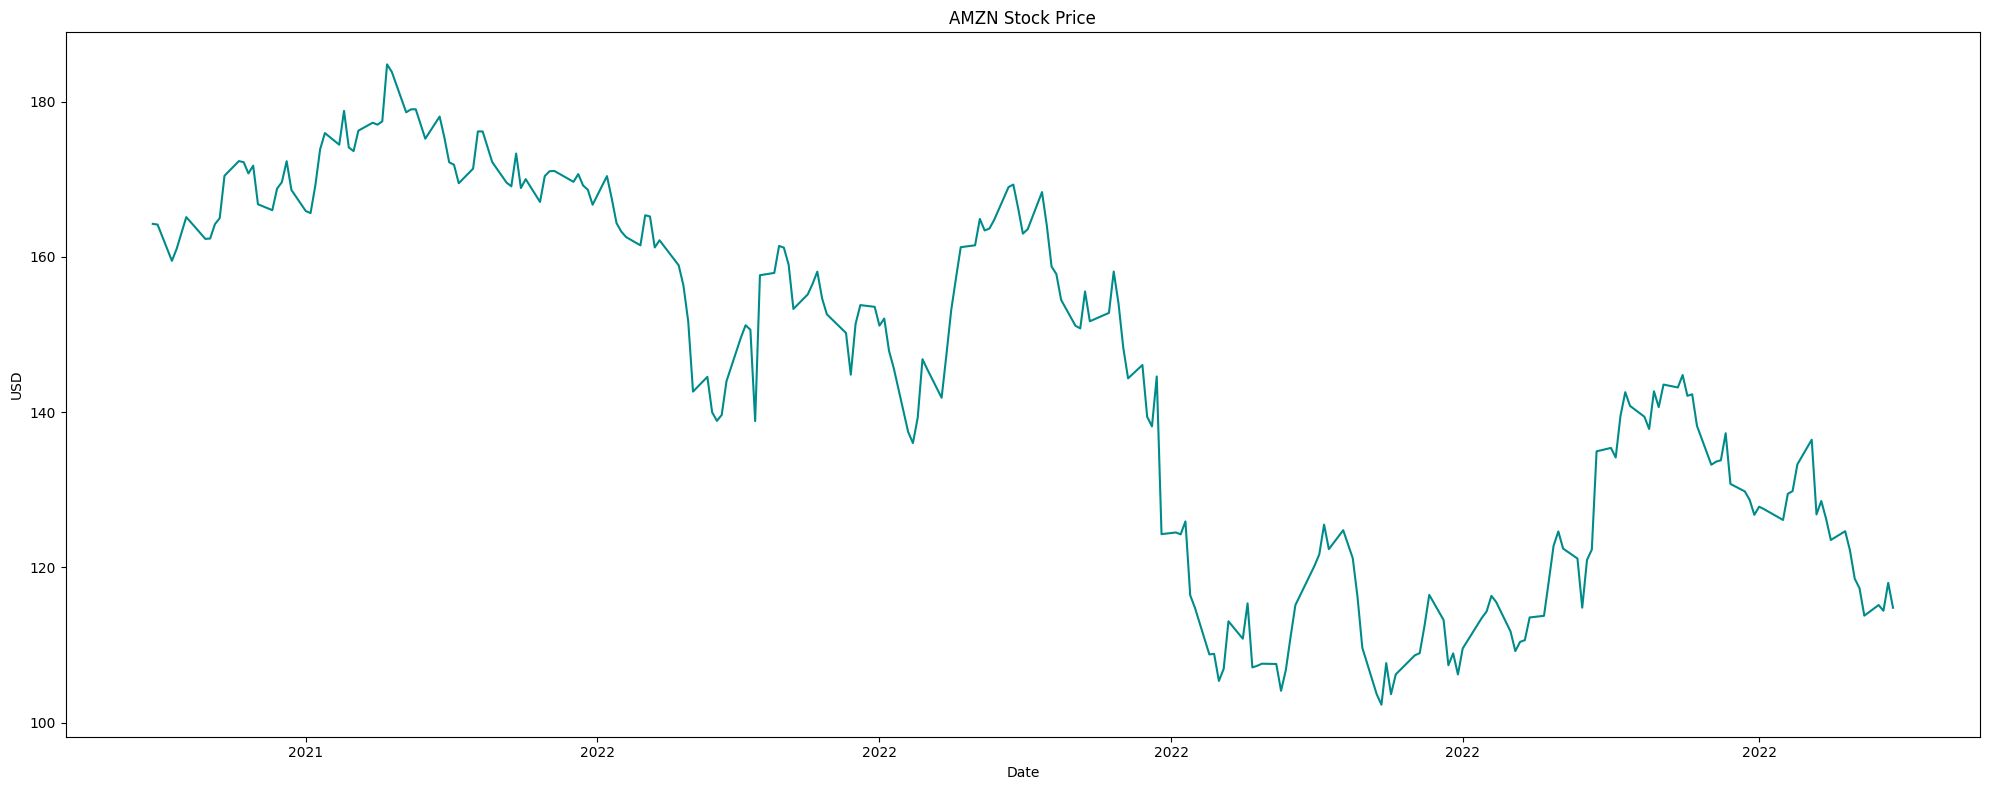

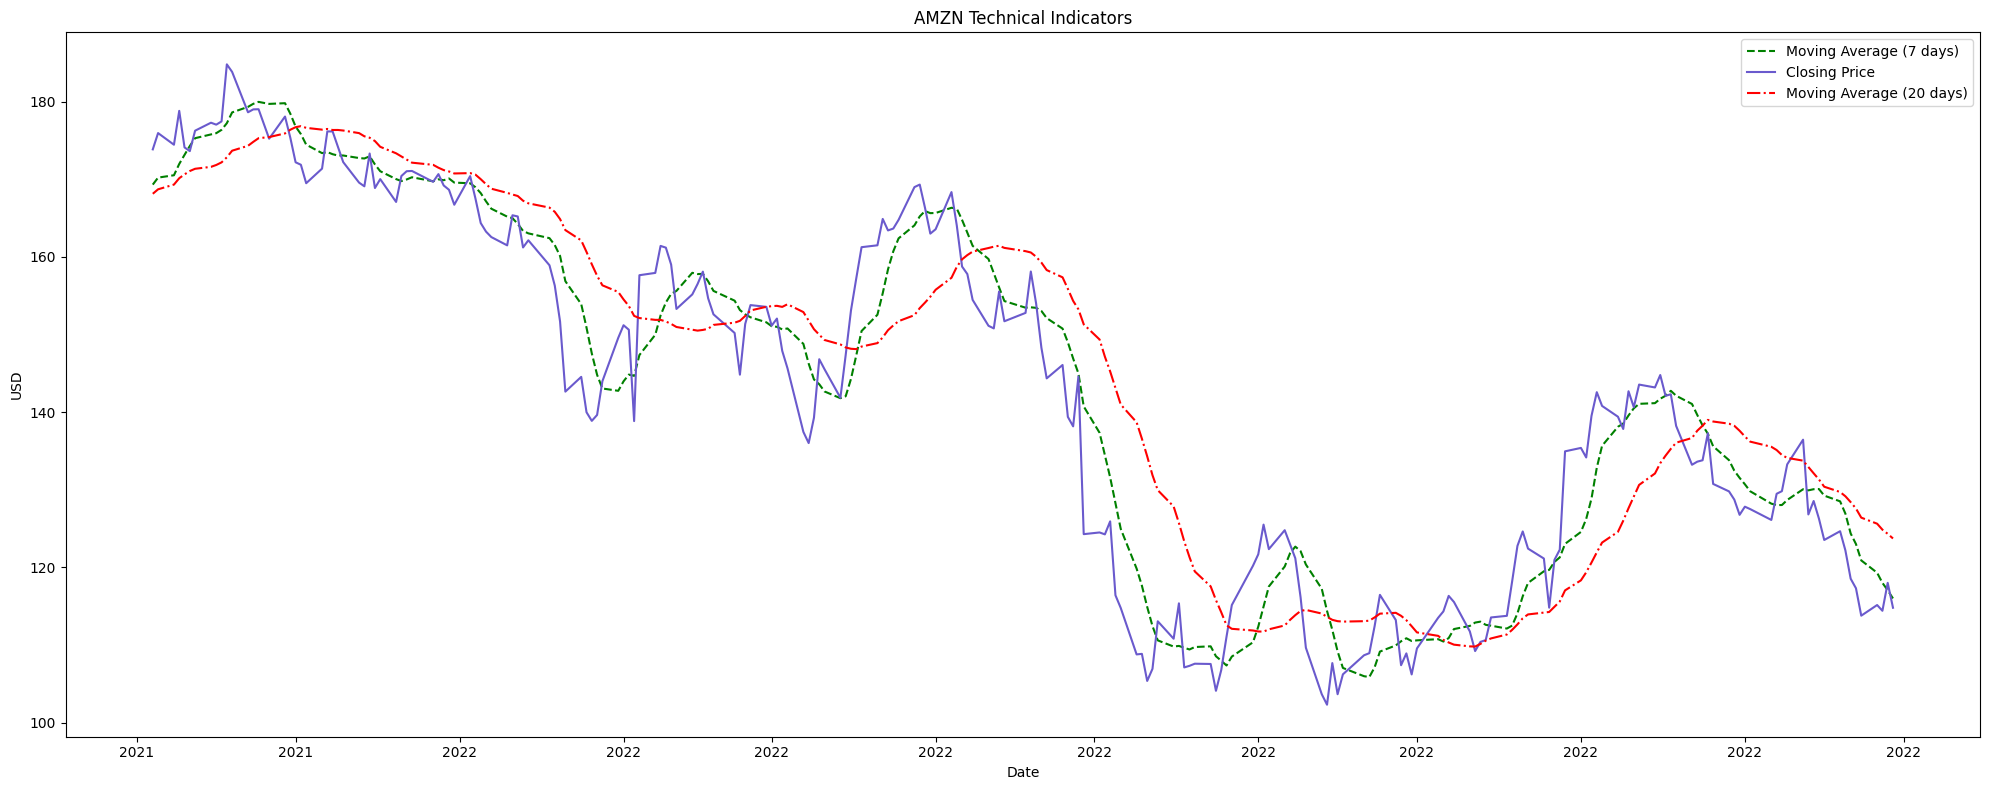

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_28 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

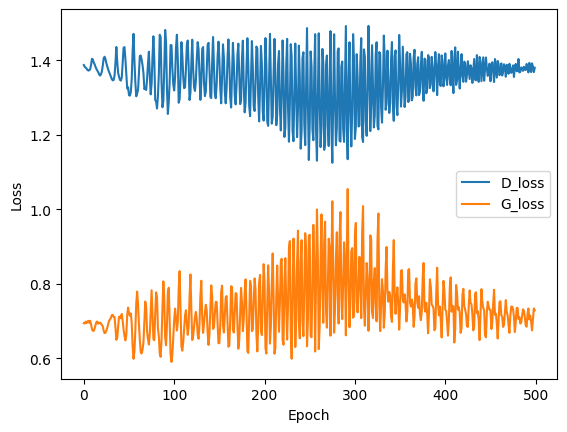

Training RMSE 0.06498198548901096


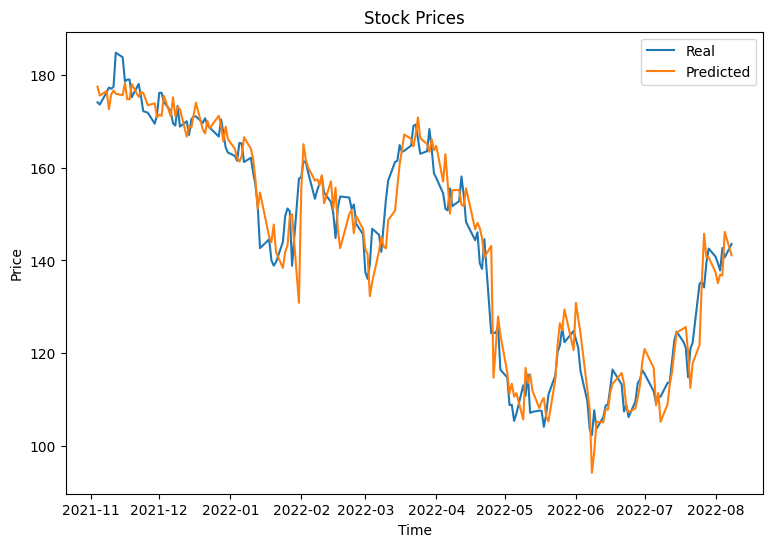

Test RMSE 3.5157713418177616


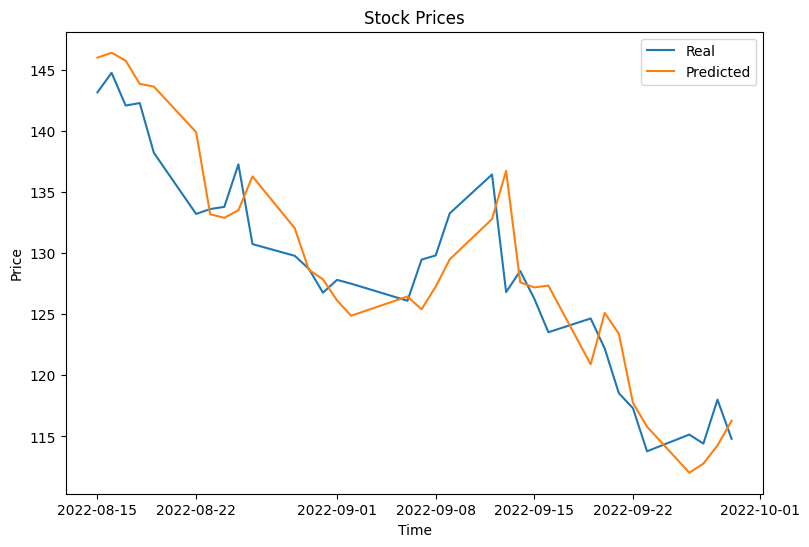

In [ ]:
parameters = [1e-3, 500]
# Preprocessing the dataset
X, y, date = clean_data(all_tweets, all_stocks, 'AMZN') 
# Obtaining splitted dataset
X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days_to_consider, days_to_predict)

gen_model = make_generator_model(days_to_consider, X_train.shape[2], days_to_predict) # Initialising generator model
print(gen_model.summary())

disc_model = make_discriminator_model(days_to_predict, days_to_consider) # Initialising discriminator model
print(disc_model.summary())

dir_path = '/content/models_gan'

if os.path.exists(dir_path):
  shutil.rmtree(dir_path)
else:
  print(f"Directory '{dir_path}' does not exist.")

gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss) # Initialising GAN architecture 
Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan) # Obtaining the results
print('Training RMSE', RMSE)

rescaled_Real_price = y_scaler.inverse_transform(Real_price) # Transforming real price
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price) # Transforming predicted price

fig, ax = plt.subplots(figsize=(9,6))

# Plot the prices
ax.plot(date[:X_train.shape[0]], rescaled_Real_price, label='Real')
ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
# Set the labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add labels
ax.set_title('Stock Prices')
# Add legend
ax.legend()
plt.show()


gen_model_best = tf.keras.models.load_model('/content/models_gan/generator_V_499.h5') # Load the best model, in this case, the model from the last epoch

y_test_predicted = gen_model_best(X_test) # Obtaining generated prices for test data
real_y = y_scaler.inverse_transform(y_test) # rescaling prices back to the original scale
predicted_y = y_scaler.inverse_transform(y_test_predicted) # rescaling prices back to the original scale
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y)) # Calculating test RMSE
print('Test RMSE', Test_RMSE)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the prediction and real price
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Stock Prices')
ax.legend()

plt.show()

## Stock Prediction for 'TSLA'

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.91 µs


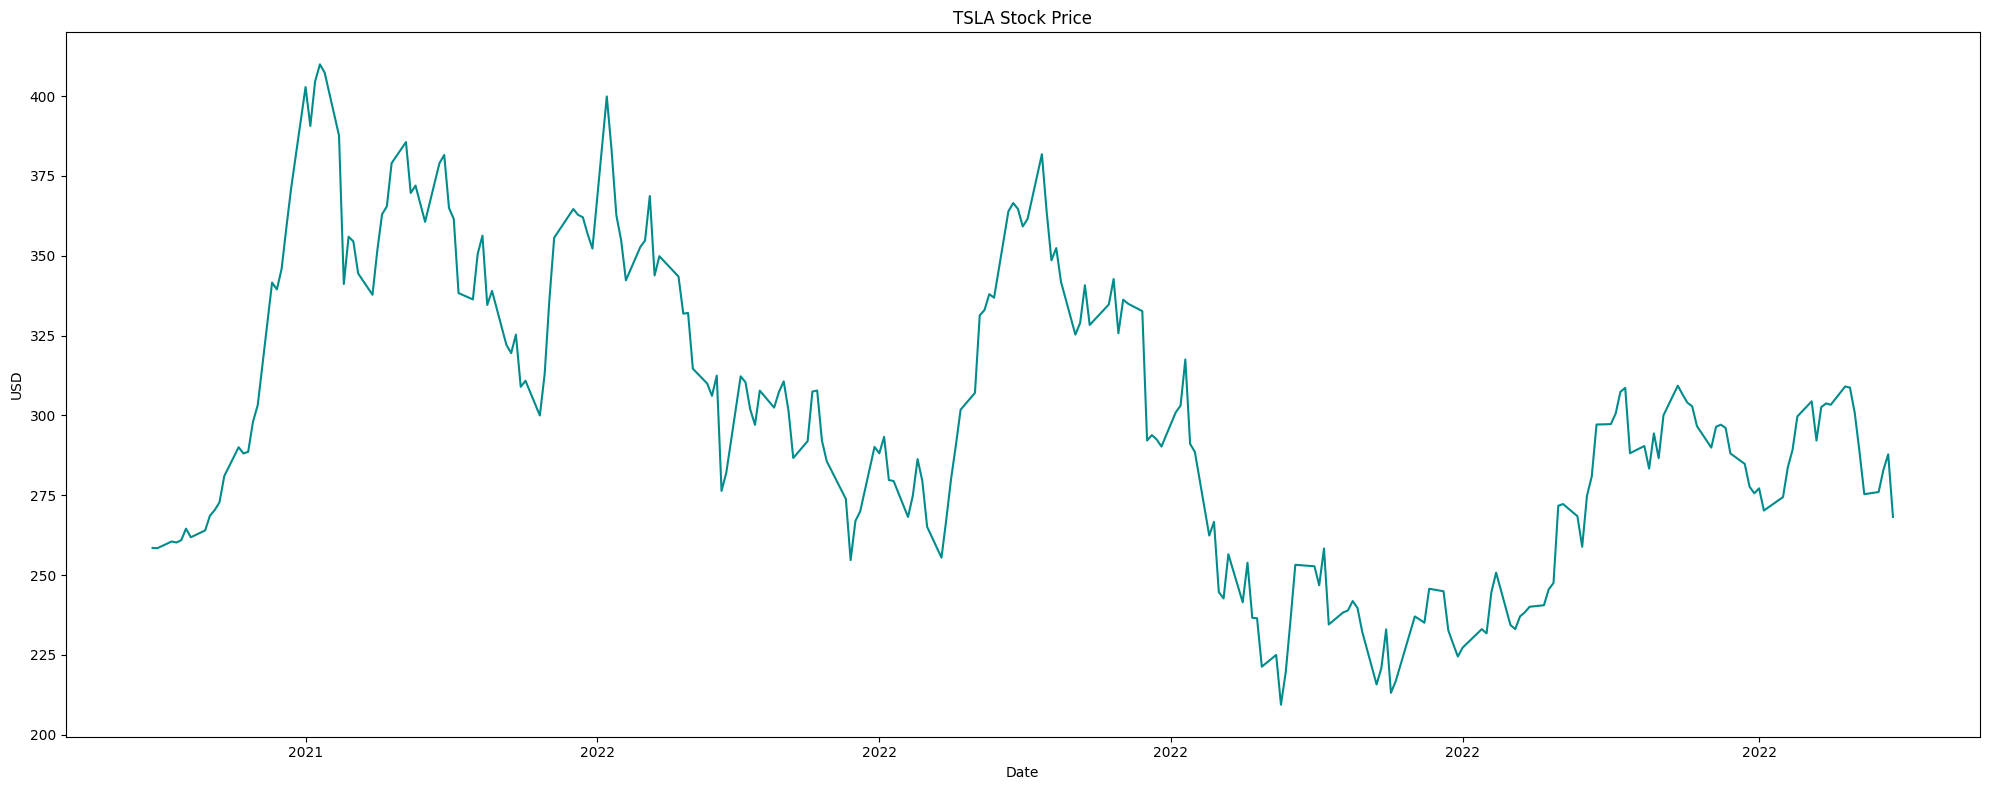

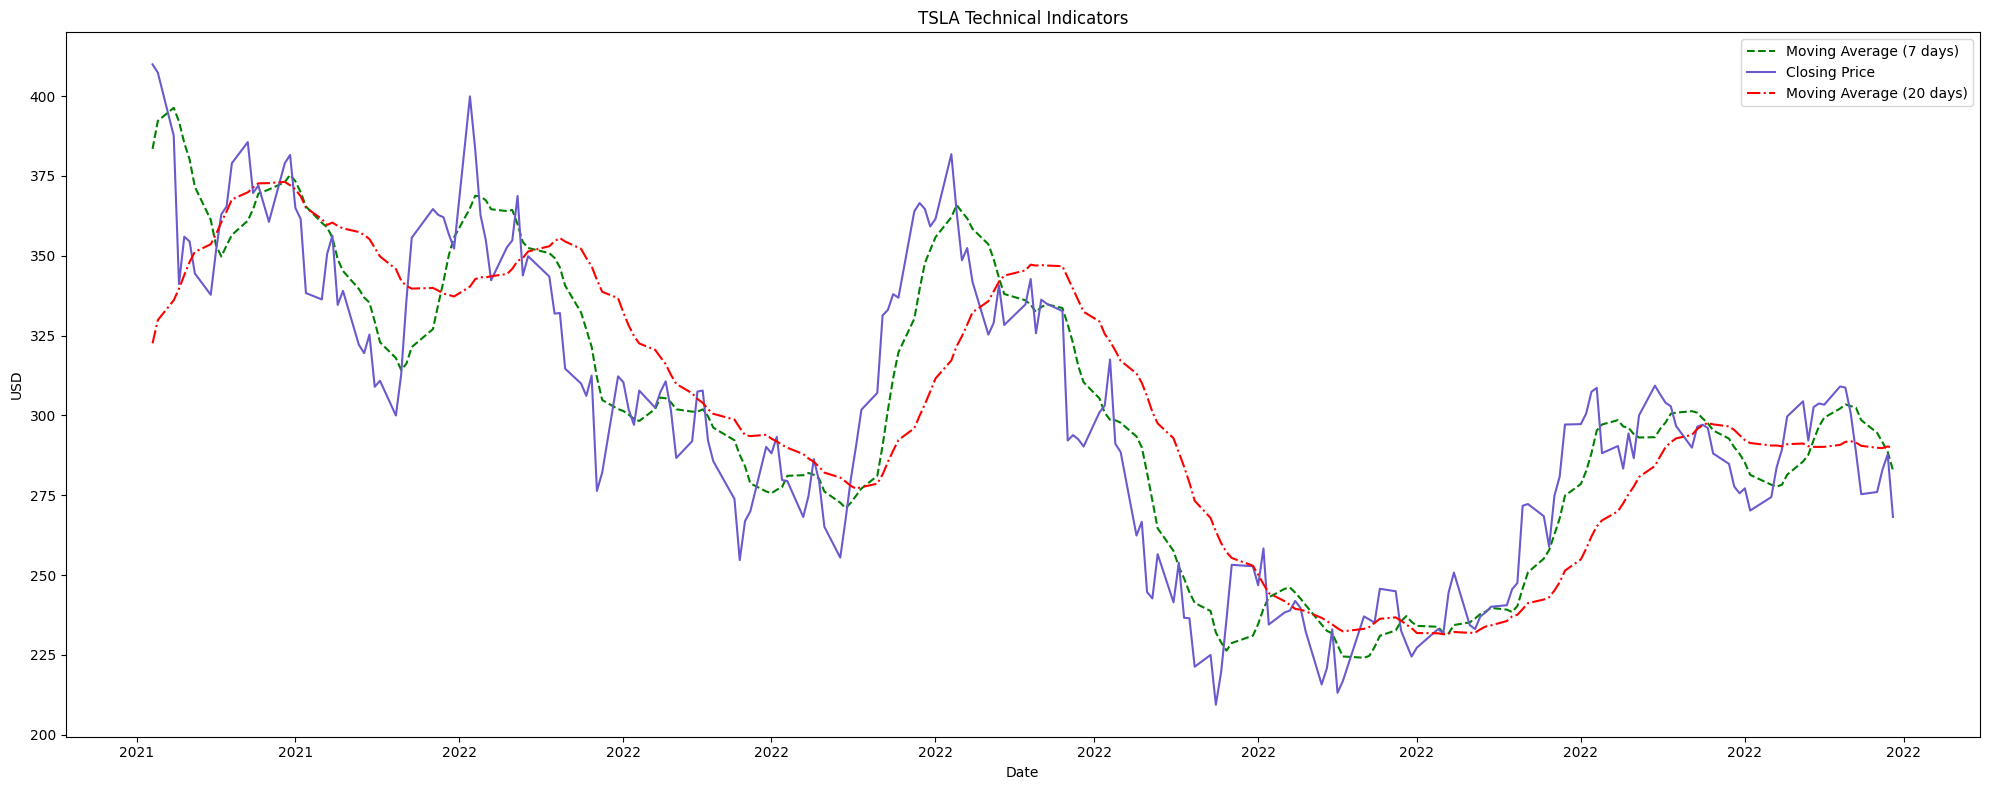

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_105 (LSTM)             (None, 4, 128)            72704     
                                                                 
 lstm_106 (LSTM)             (None, 4, 64)             49408     
                                                                 
 lstm_107 (LSTM)             (None, 32)                12416     
                                                                 
 dense_70 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

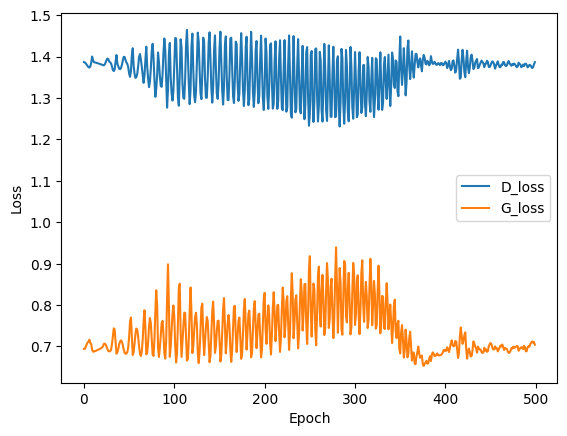

Training RMSE 0.07439223875028952


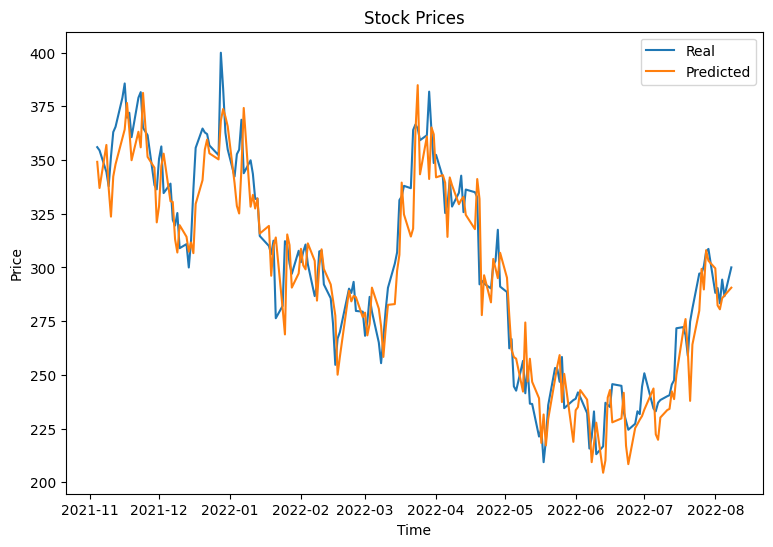

Test RMSE 8.86369876840866


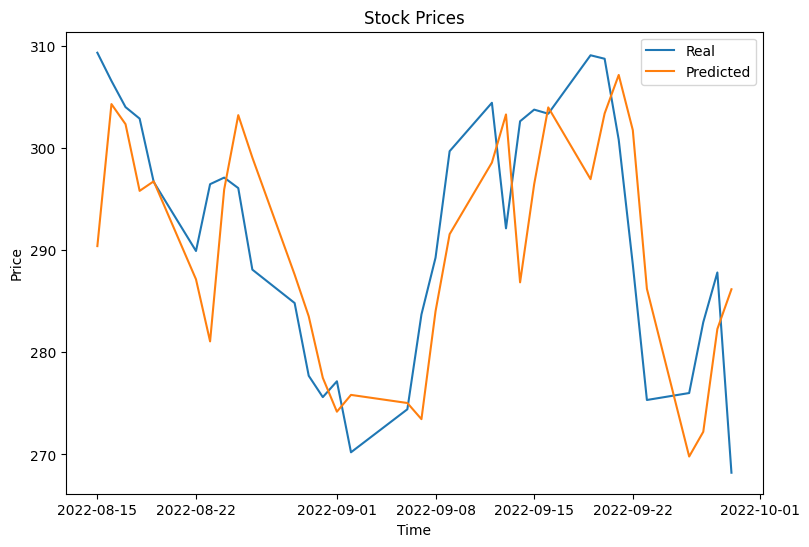

In [ ]:
parameters = [1e-3, 500]
X, y, date = clean_data(all_tweets, all_stocks, 'TSLA')
X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days_to_consider, days_to_predict)

gen_model = make_generator_model(days_to_consider, X_train.shape[2], days_to_predict)
print(gen_model.summary())

disc_model = make_discriminator_model(days_to_predict, days_to_consider)
print(disc_model.summary())

dir_path = '/content/models_gan'

if os.path.exists(dir_path):
  shutil.rmtree(dir_path)
else:
  print(f"Directory '{dir_path}' does not exist.")

gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss)
Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan)
print('Training RMSE', RMSE)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[:X_train.shape[0]], rescaled_Real_price, label='Real')
ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()


gen_model_best = tf.keras.models.load_model('/content/models_gan/generator_V_499.h5')
#gen_model_best.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3,  beta_1=0.5), loss = tf.keras.losses.BinaryCrossentropy())

y_test_predicted = gen_model_best(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print('Test RMSE', Test_RMSE)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()

## Stock Prediction for 'TSM'

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


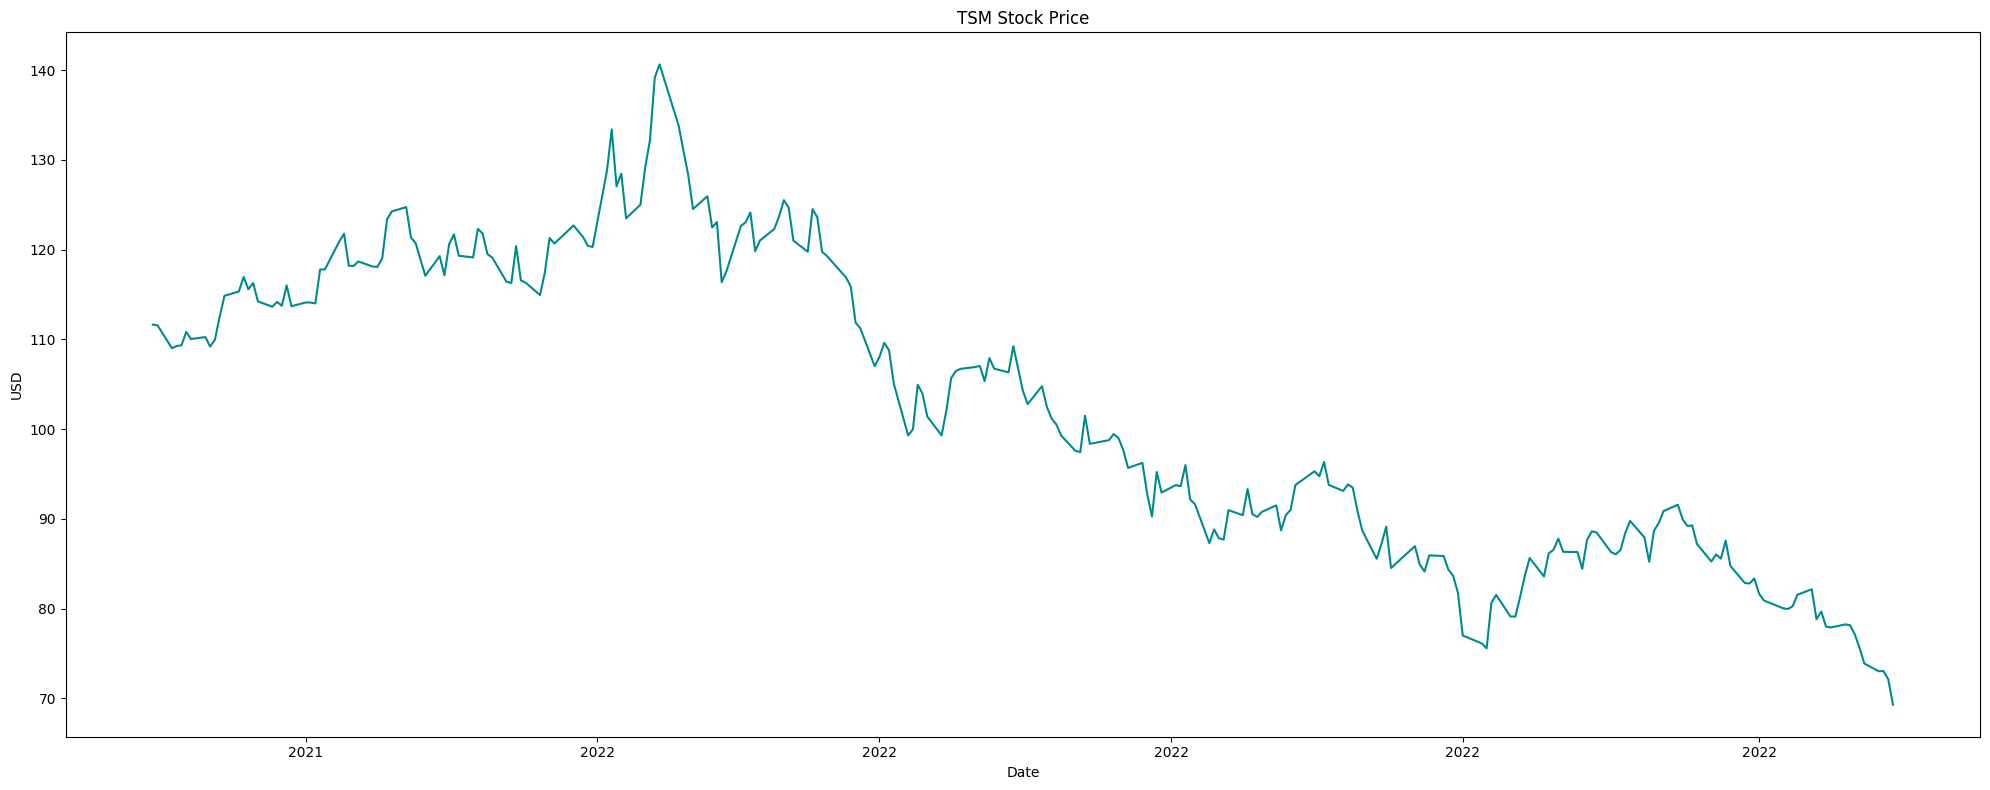

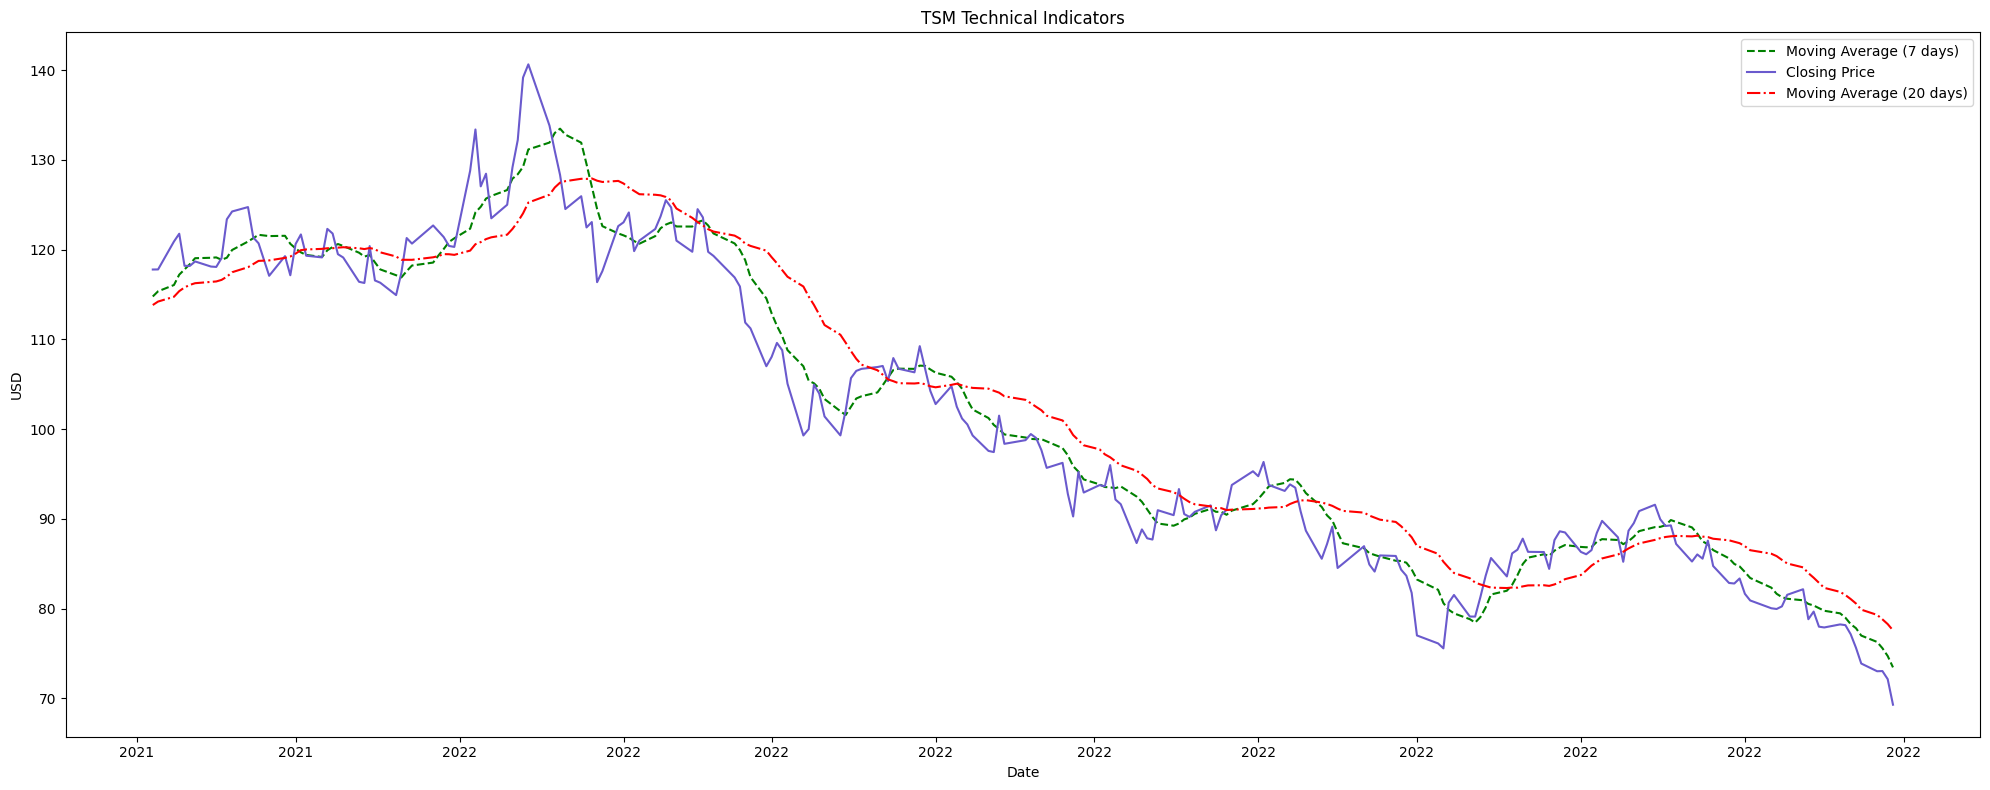

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_70 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_71 (LSTM)              (None, 32)                12416     
                                                                 
 dense_46 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

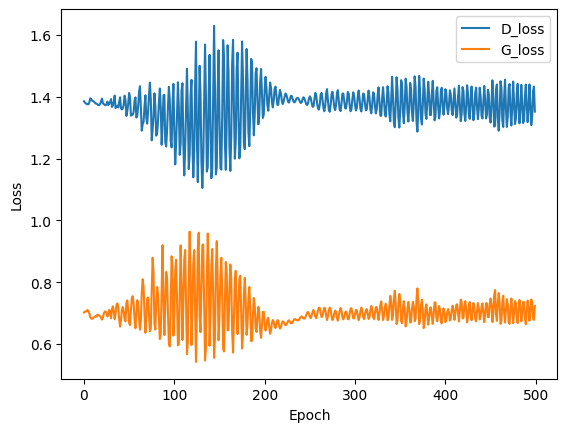

Training RMSE 0.09131425881578993


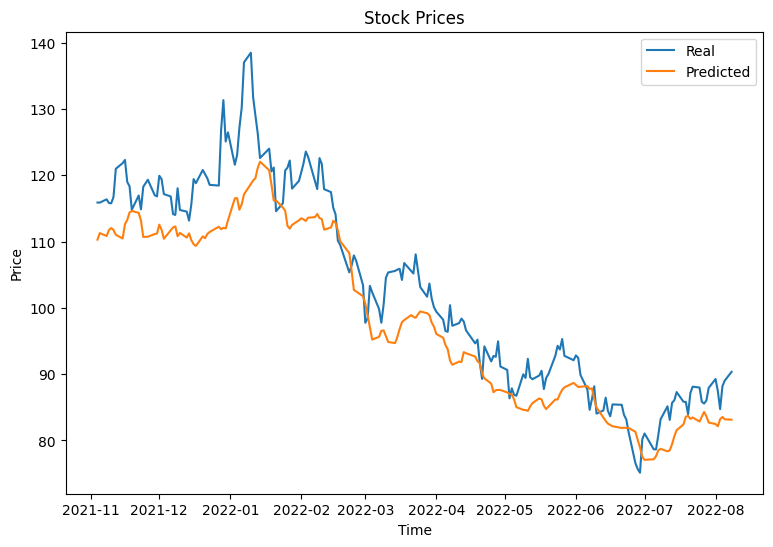

Test RMSE 2.718390260229363


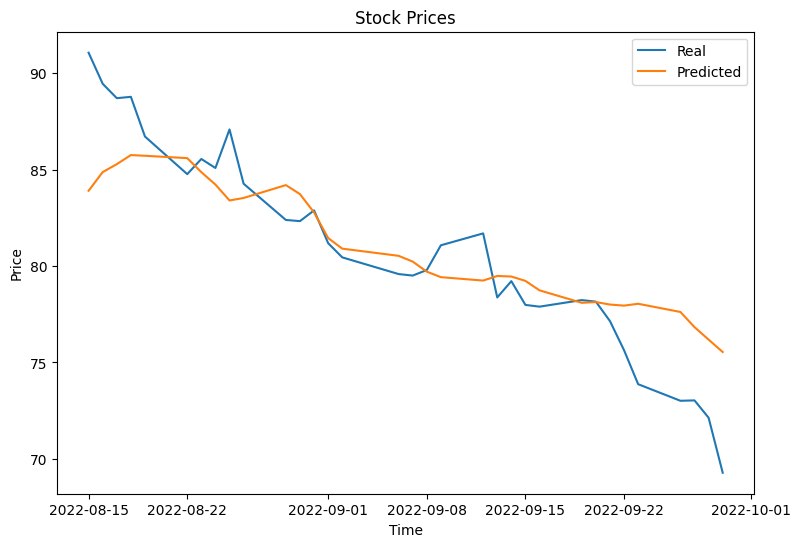

In [ ]:
parameters = [1e-3, 500]
X, y, date = clean_data(all_tweets, all_stocks, 'TSM')
X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days_to_consider, days_to_predict)

gen_model = make_generator_model(days_to_consider, X_train.shape[2], days_to_predict)
print(gen_model.summary())

disc_model = make_discriminator_model(days_to_predict, days_to_consider)
print(disc_model.summary())

dir_path = '/content/models_gan'

if os.path.exists(dir_path):
  shutil.rmtree(dir_path)
else:
  print(f"Directory '{dir_path}' does not exist.")

gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss)
Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan)
print('Training RMSE', RMSE)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[:X_train.shape[0]], rescaled_Real_price, label='Real')
ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()


gen_model_best = tf.keras.models.load_model('/content/models_gan/generator_V_499.h5')
#gen_model_best.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3,  beta_1=0.5), loss = tf.keras.losses.BinaryCrossentropy())

y_test_predicted = gen_model_best(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print('Test RMSE', Test_RMSE)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()

## Stock Prediction for 'AAPL'

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


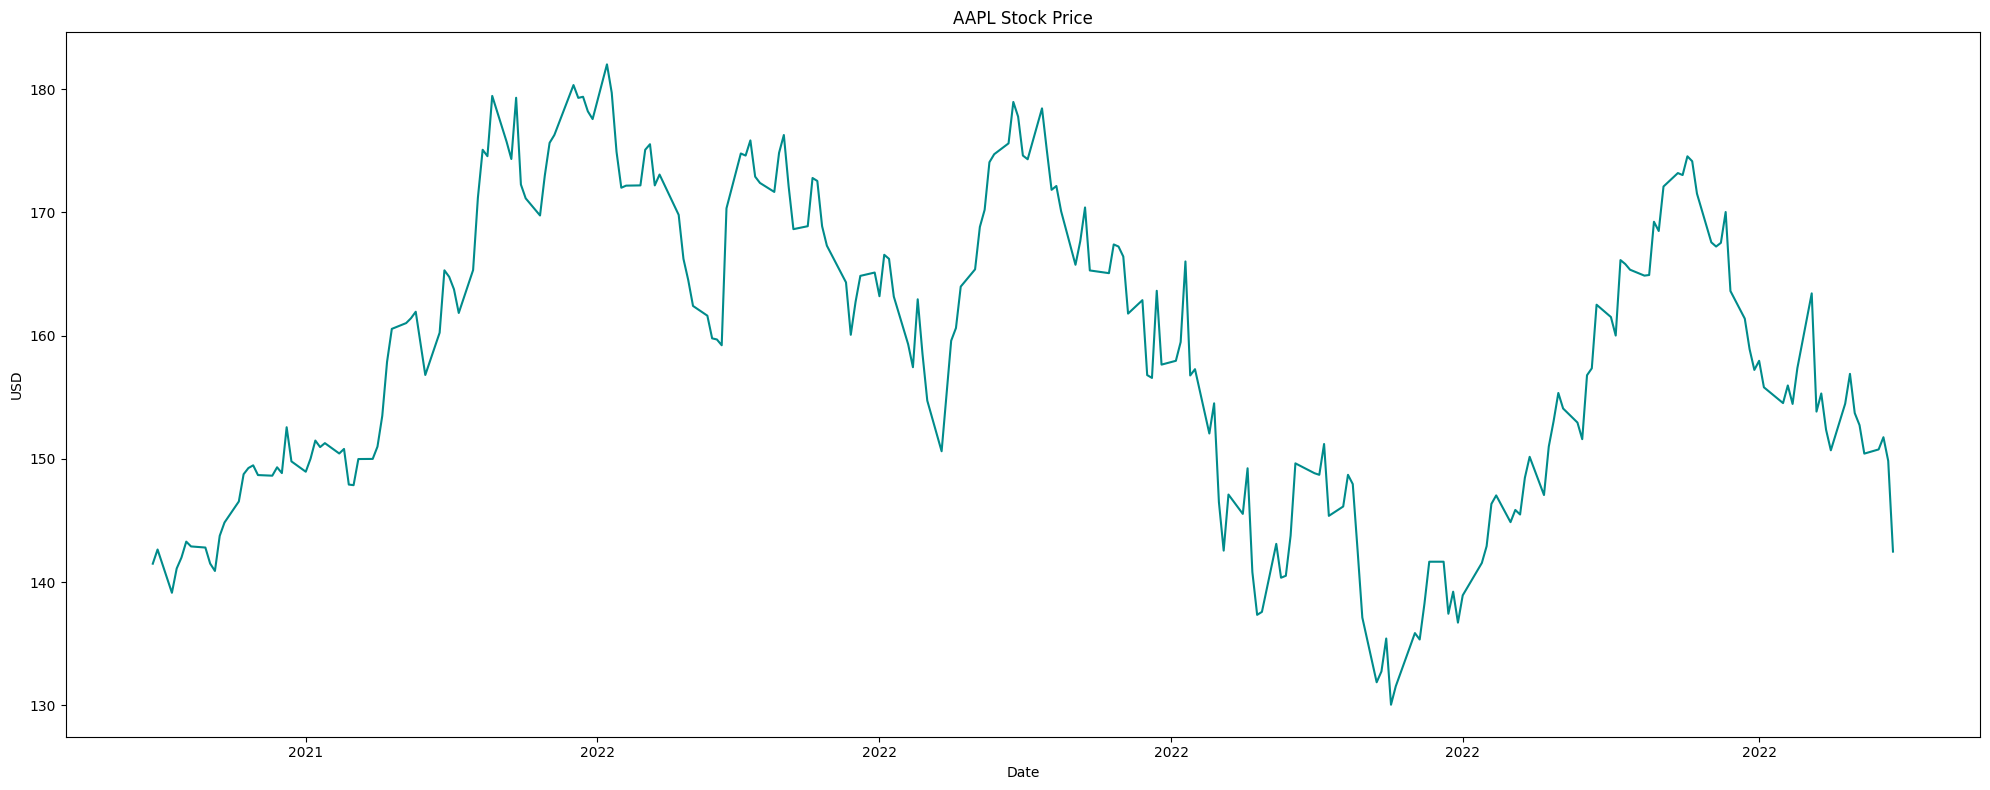

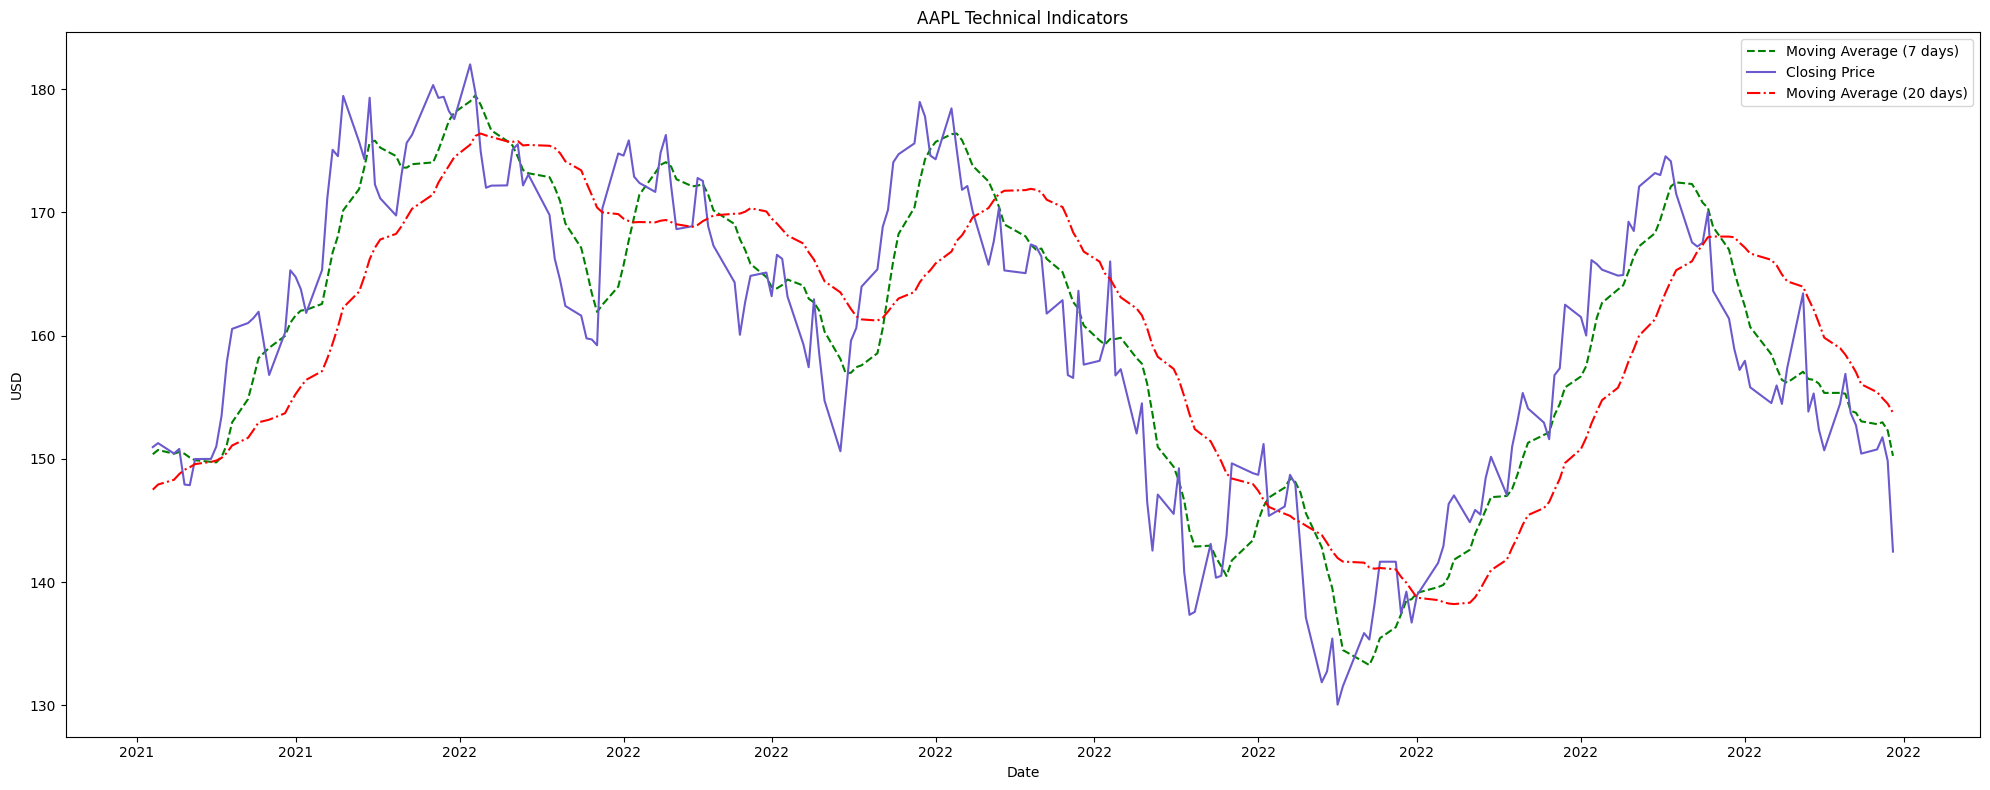

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_73 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_74 (LSTM)              (None, 32)                12416     
                                                                 
 dense_48 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

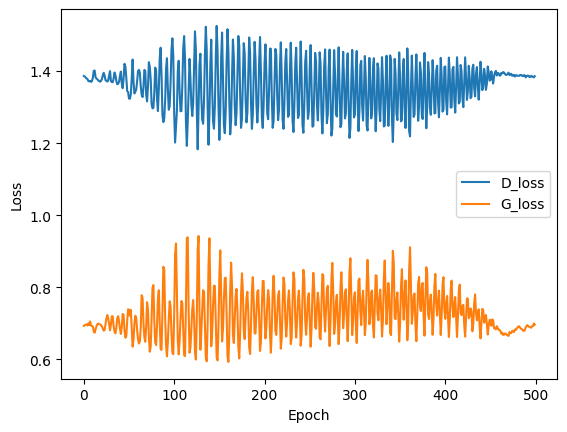

Training RMSE 0.10040075479486621


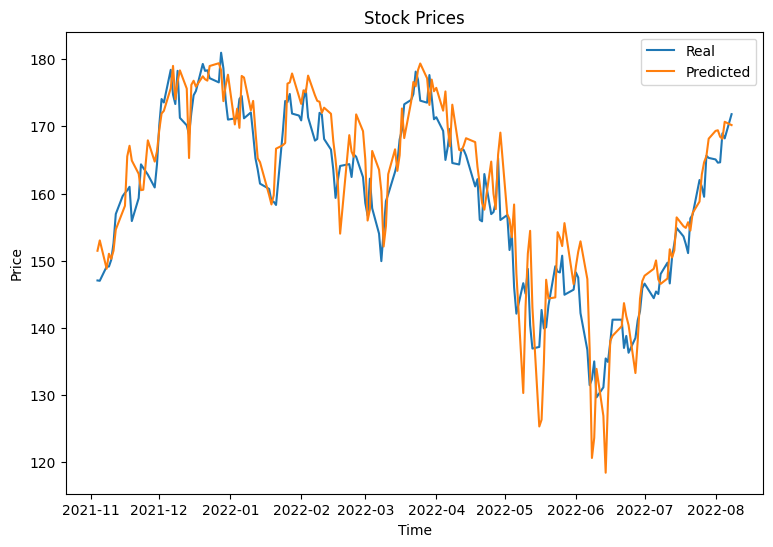

Test RMSE 4.6635777175181525


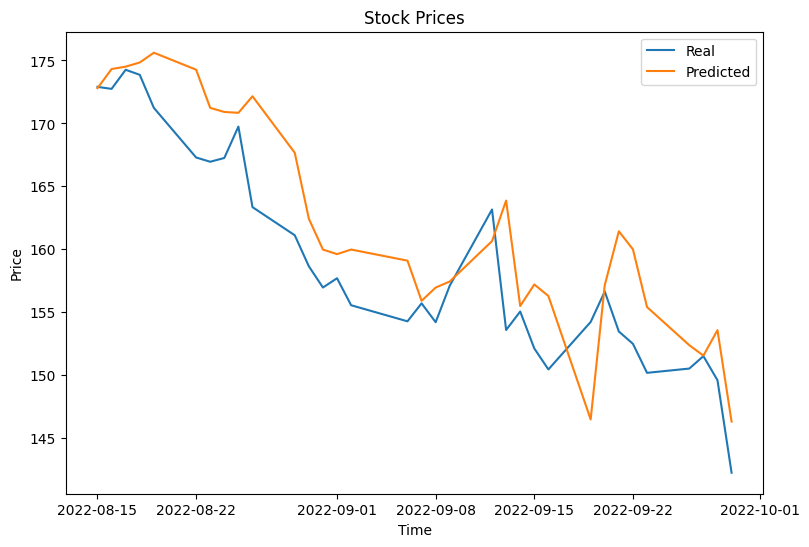

In [ ]:
parameters = [1e-3, 500]
X, y, date = clean_data(all_tweets, all_stocks, 'AAPL')
X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days_to_consider, days_to_predict)

gen_model = make_generator_model(days_to_consider, X_train.shape[2], days_to_predict)
print(gen_model.summary())

disc_model = make_discriminator_model(days_to_predict, days_to_consider)
print(disc_model.summary())

dir_path = '/content/models_gan'

if os.path.exists(dir_path):
  shutil.rmtree(dir_path)
else:
  print(f"Directory '{dir_path}' does not exist.")

gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss)
Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan)
print('Training RMSE', RMSE)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[:X_train.shape[0]], rescaled_Real_price, label='Real')
ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()


gen_model_best = tf.keras.models.load_model('/content/models_gan/generator_V_499.h5')
#gen_model_best.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3,  beta_1=0.5), loss = tf.keras.losses.BinaryCrossentropy())

y_test_predicted = gen_model_best(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print('Test RMSE', Test_RMSE)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()

## Stock Prediction for 'PG'

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


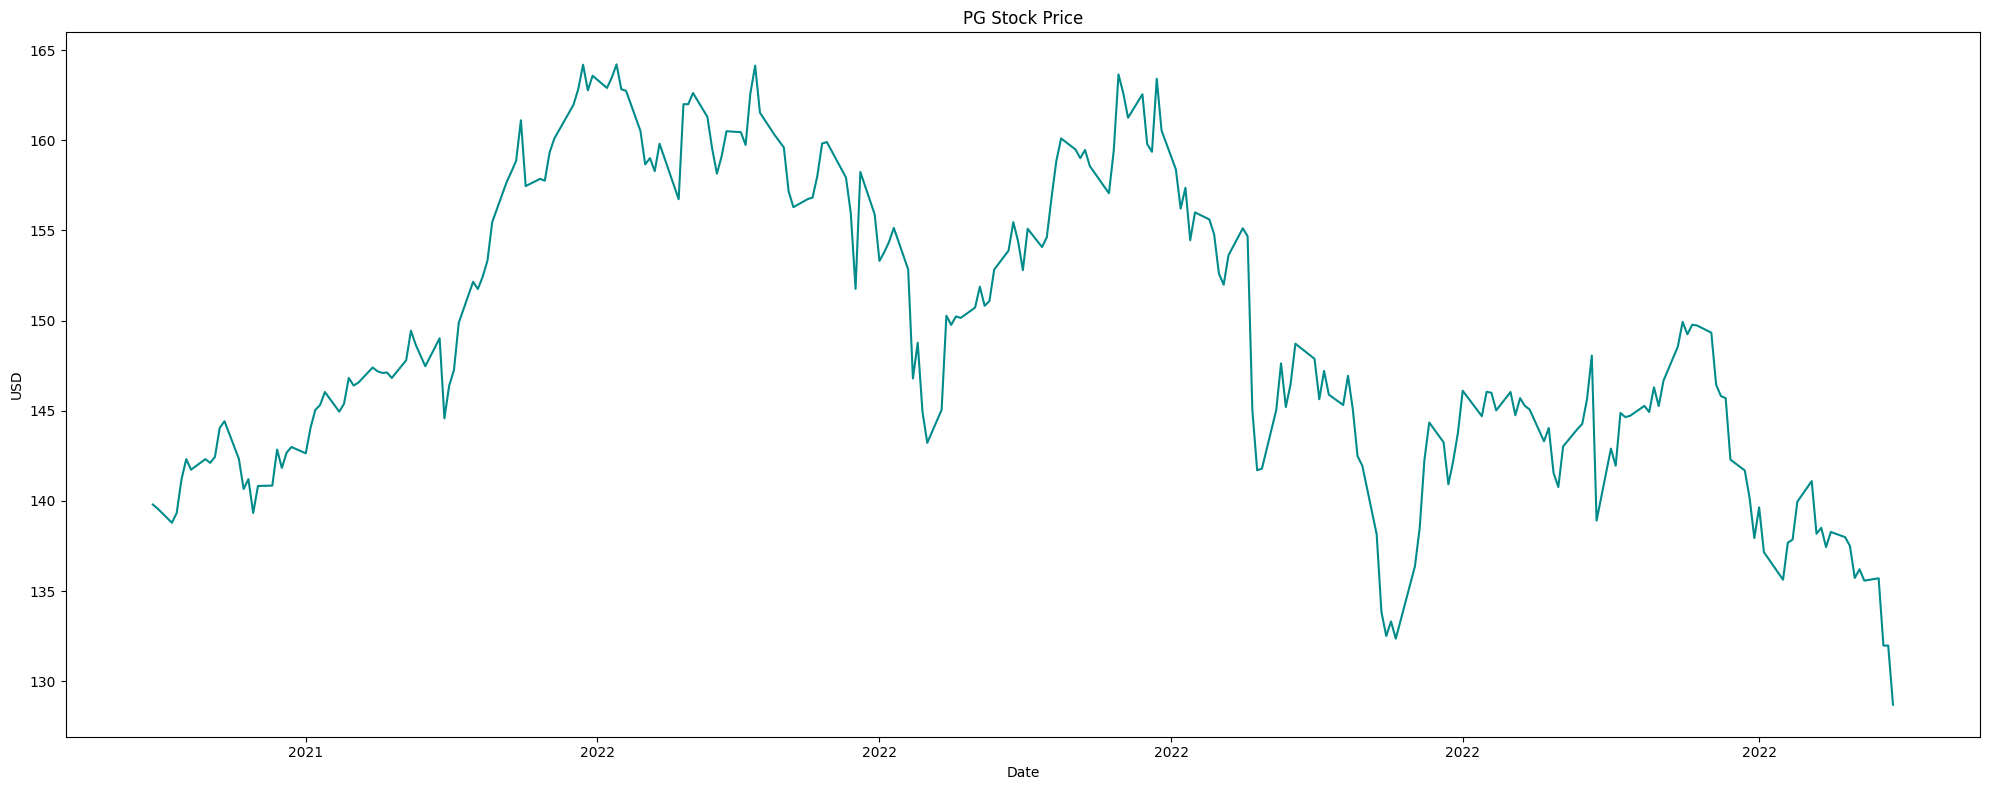

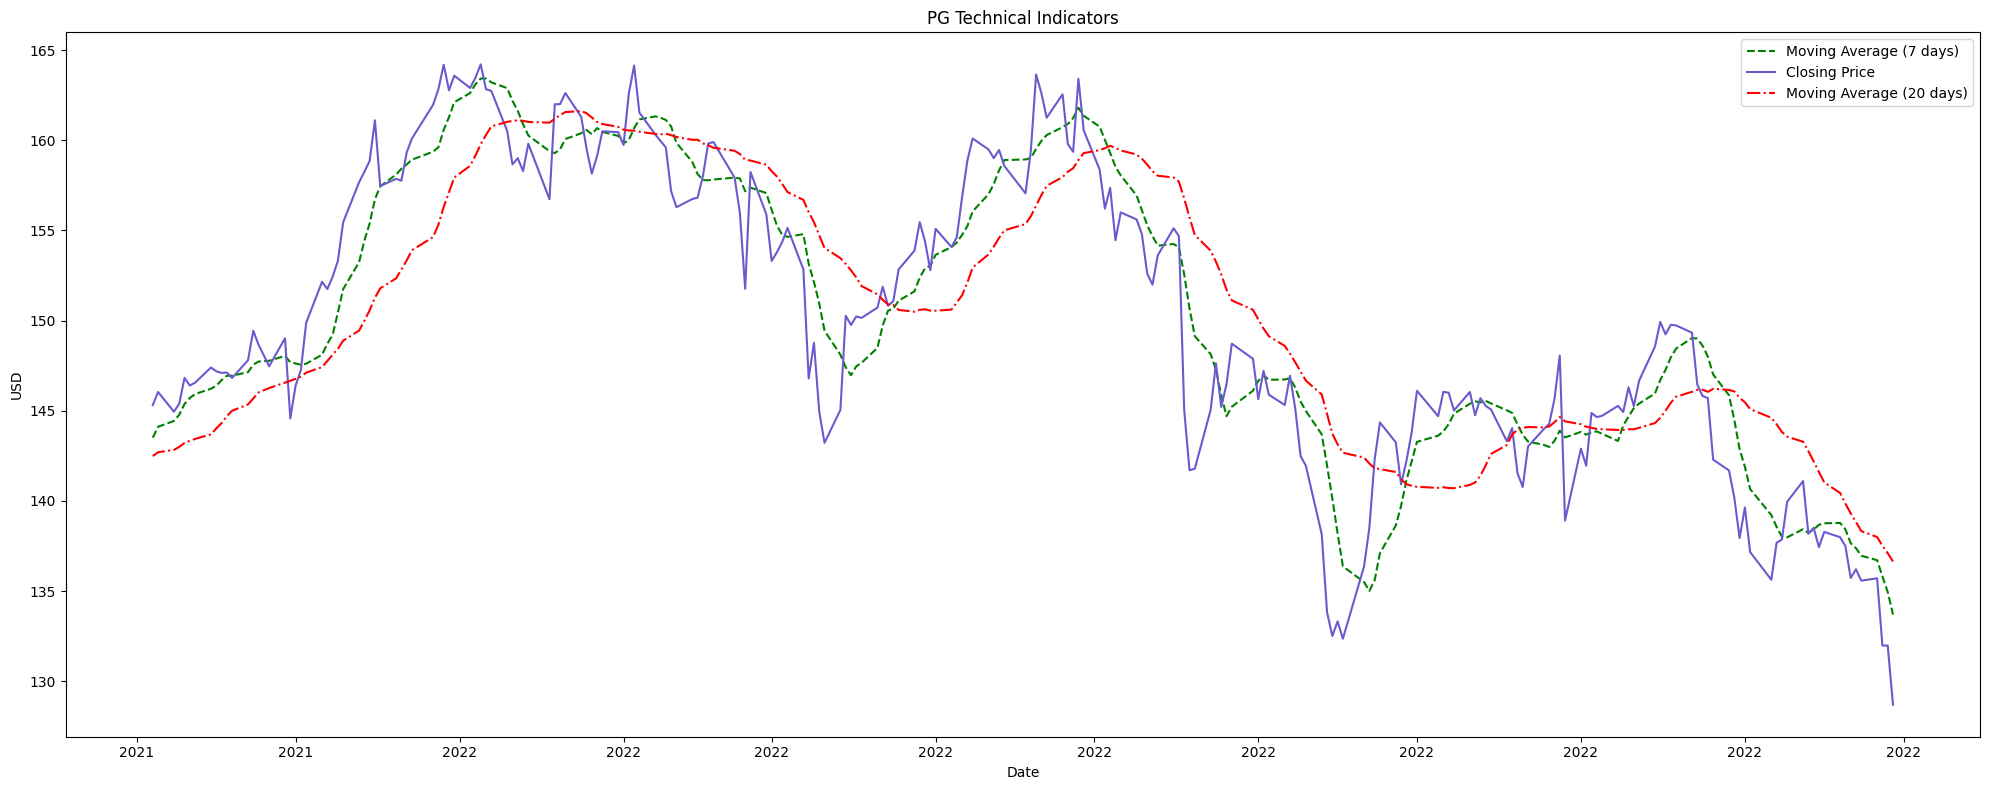

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_76 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_77 (LSTM)              (None, 32)                12416     
                                                                 
 dense_50 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

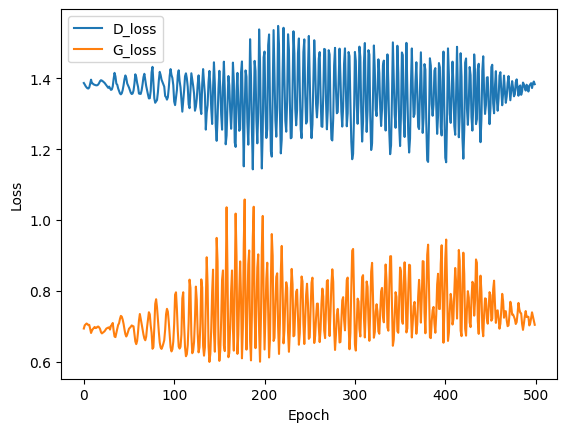

Training RMSE 0.07842409438713507


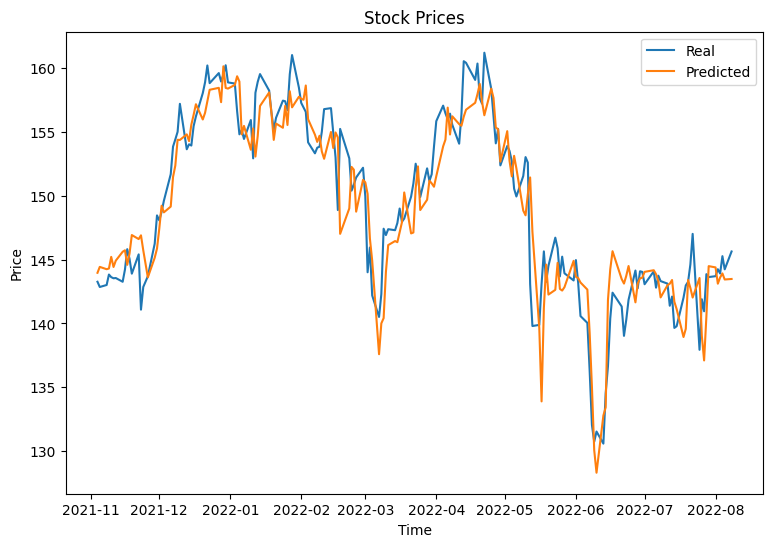

Test RMSE 4.191214264243543


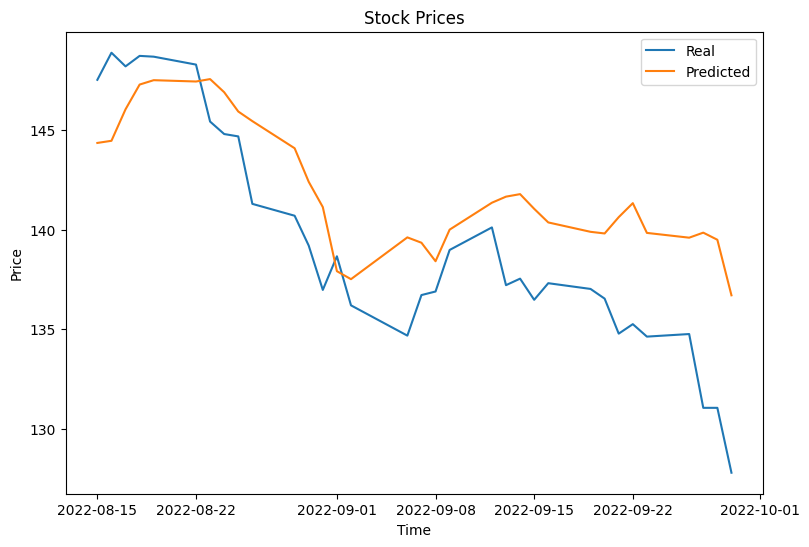

In [ ]:
parameters = [1e-3, 500]
X, y, date = clean_data(all_tweets, all_stocks, 'PG')
X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days_to_consider, days_to_predict)

gen_model = make_generator_model(days_to_consider, X_train.shape[2], days_to_predict)
print(gen_model.summary())

disc_model = make_discriminator_model(days_to_predict, days_to_consider)
print(disc_model.summary())

dir_path = '/content/models_gan'

if os.path.exists(dir_path):
  shutil.rmtree(dir_path)
else:
  print(f"Directory '{dir_path}' does not exist.")

gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss)
Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan)
print('Training RMSE', RMSE)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[:X_train.shape[0]], rescaled_Real_price, label='Real')
ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()


gen_model_best = tf.keras.models.load_model('/content/models_gan/generator_V_499.h5')
#gen_model_best.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3,  beta_1=0.5), loss = tf.keras.losses.BinaryCrossentropy())

y_test_predicted = gen_model_best(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print('Test RMSE', Test_RMSE)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()

## Stock Prediction for 'MSFT'

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


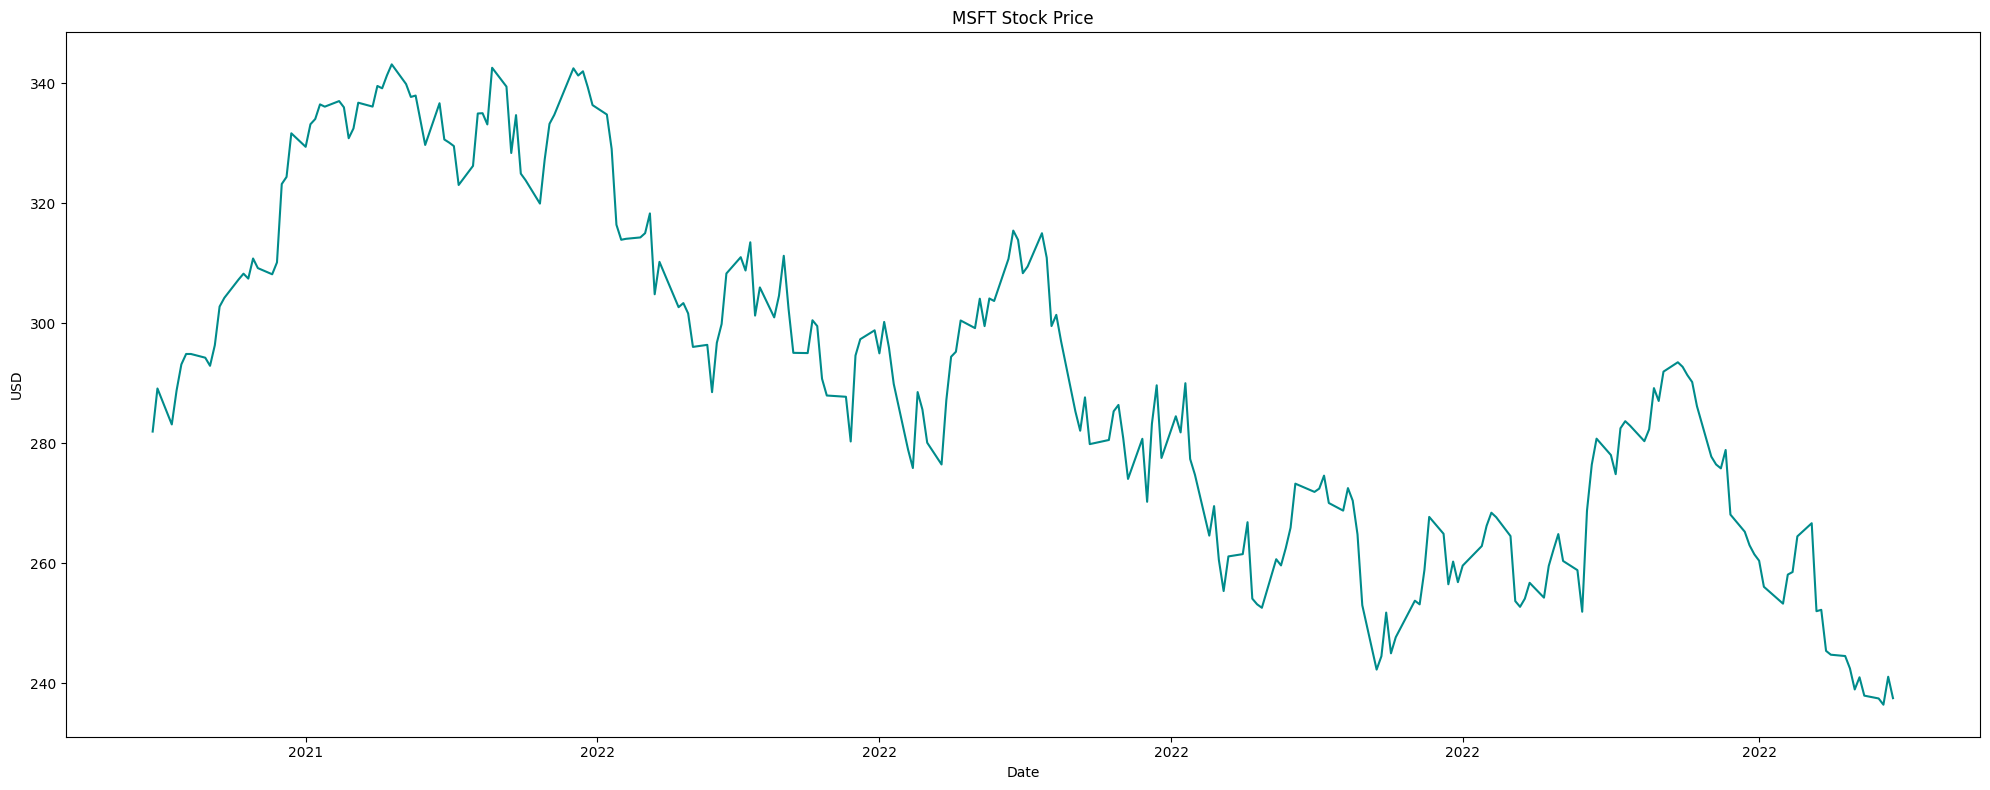

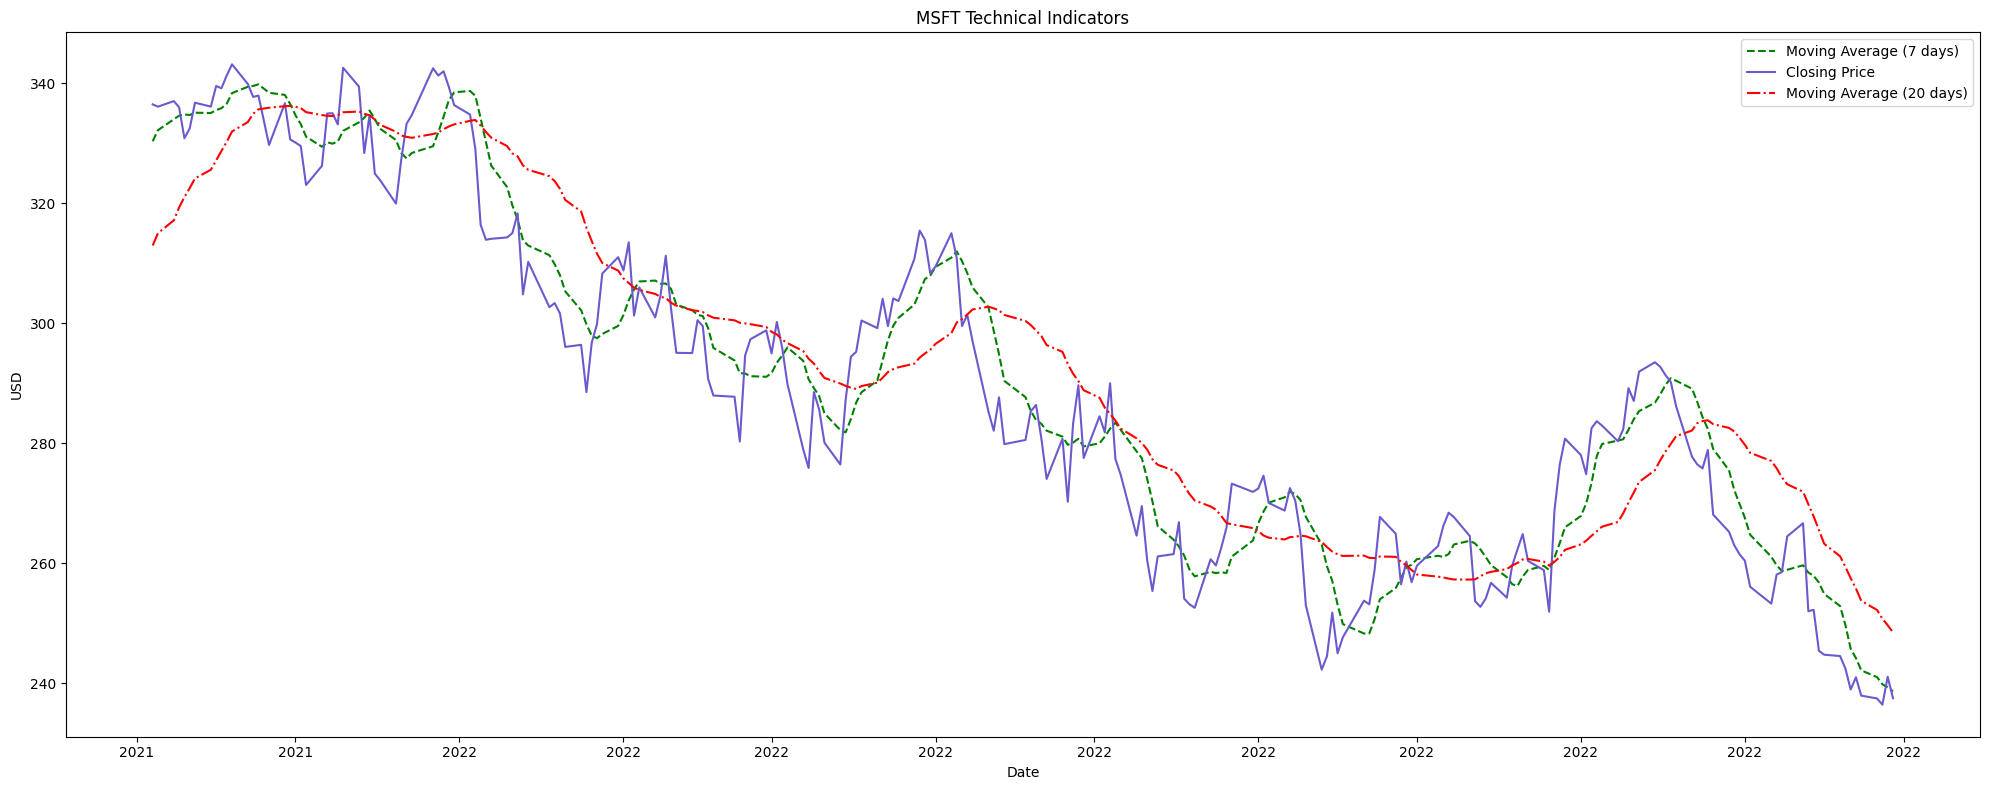

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_79 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_80 (LSTM)              (None, 32)                12416     
                                                                 
 dense_52 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

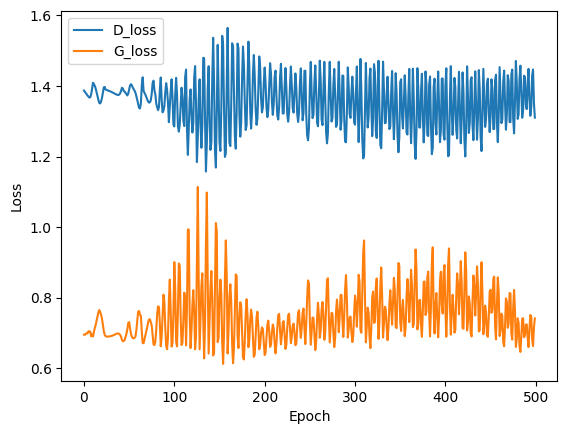

Training RMSE 0.09945719208886508


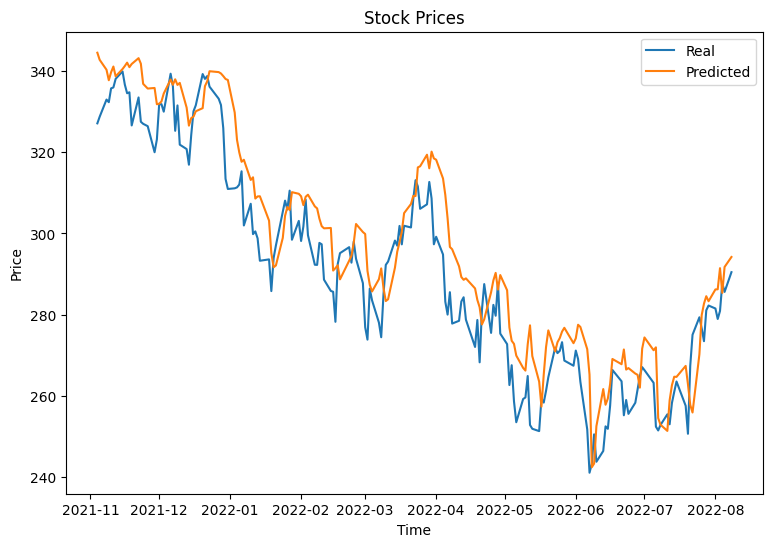

Test RMSE 9.339888501885891


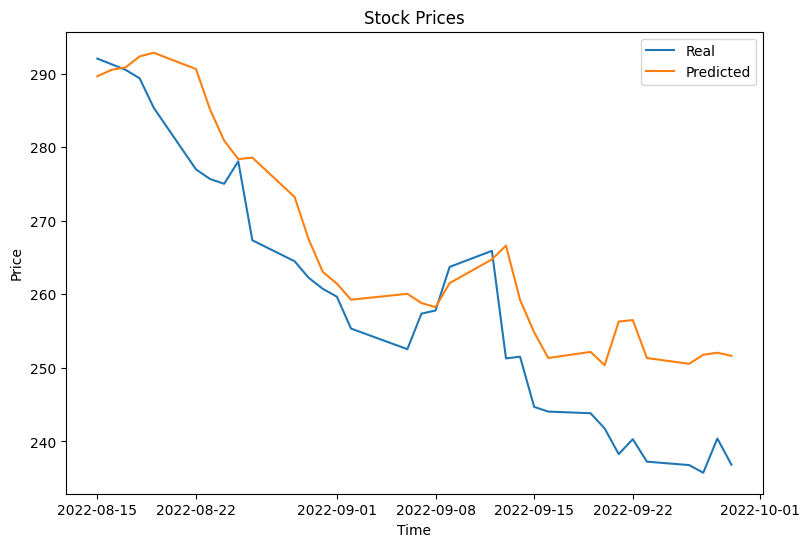

In [ ]:
parameters = [1e-3, 500]
X, y, date = clean_data(all_tweets, all_stocks, 'MSFT')
X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days_to_consider, days_to_predict)

gen_model = make_generator_model(days_to_consider, X_train.shape[2], days_to_predict)
print(gen_model.summary())

disc_model = make_discriminator_model(days_to_predict, days_to_consider)
print(disc_model.summary())

dir_path = '/content/models_gan'

if os.path.exists(dir_path):
  shutil.rmtree(dir_path)
else:
  print(f"Directory '{dir_path}' does not exist.")

gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss)
Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan)
print('Training RMSE', RMSE)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[:X_train.shape[0]], rescaled_Real_price, label='Real')
ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()


gen_model_best = tf.keras.models.load_model('/content/models_gan/generator_V_499.h5')
#gen_model_best.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3,  beta_1=0.5), loss = tf.keras.losses.BinaryCrossentropy())

y_test_predicted = gen_model_best(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print('Test RMSE', Test_RMSE)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()

## Stock Prediction for 'NIO'

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 22.9 µs


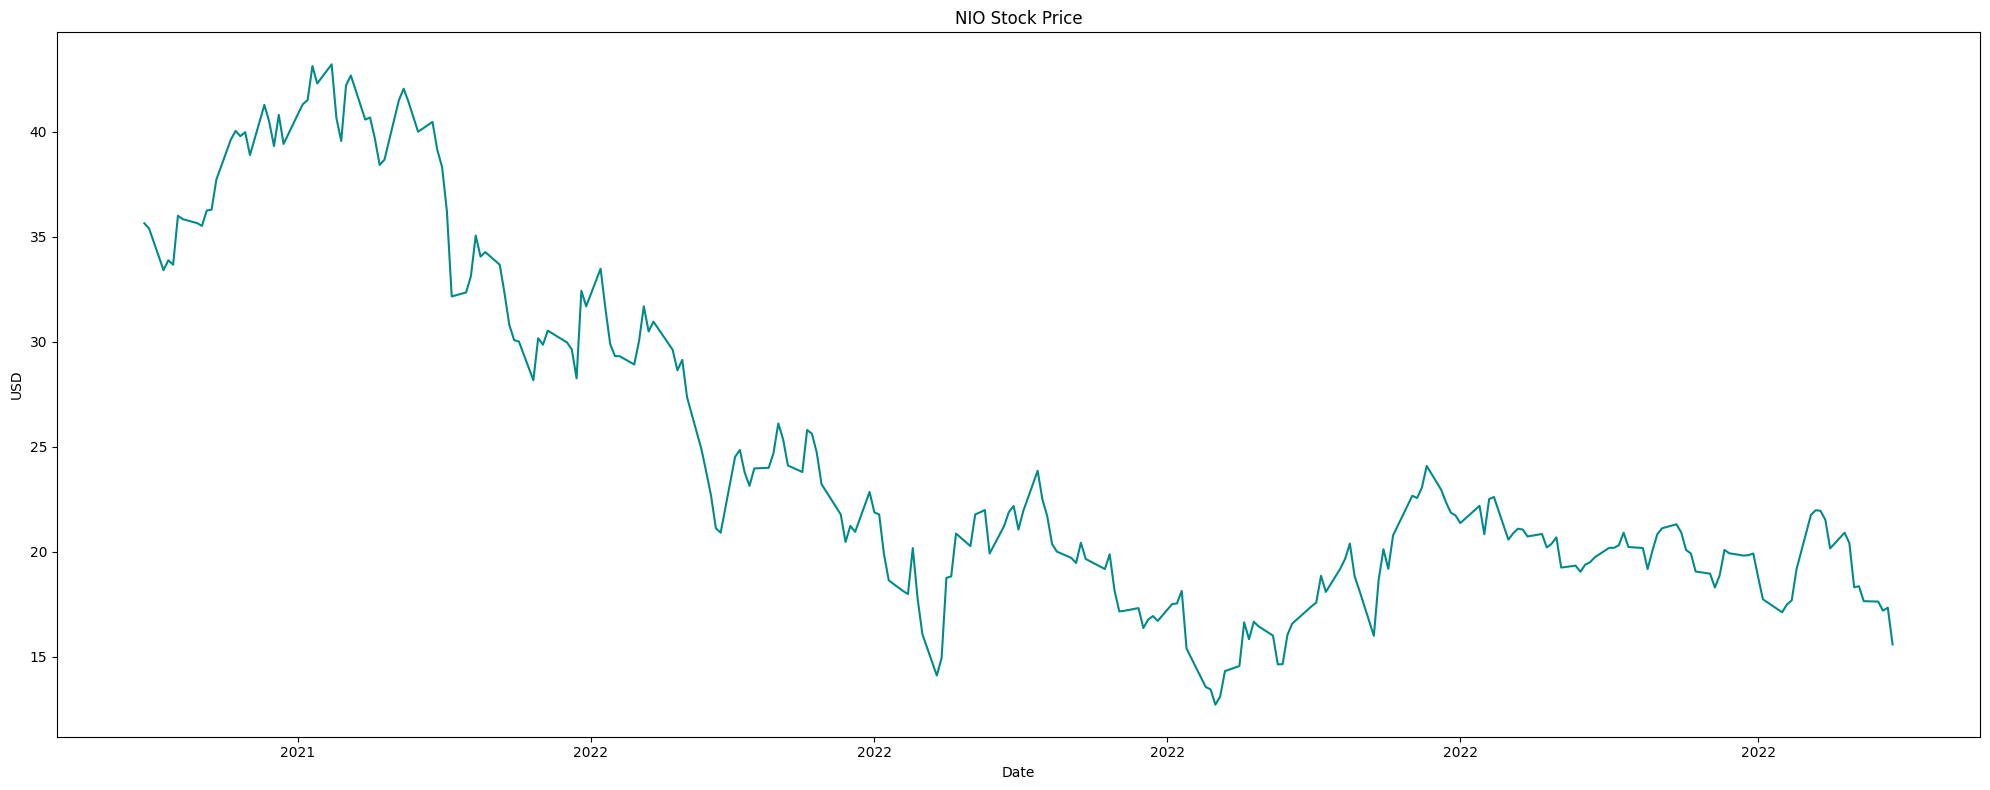

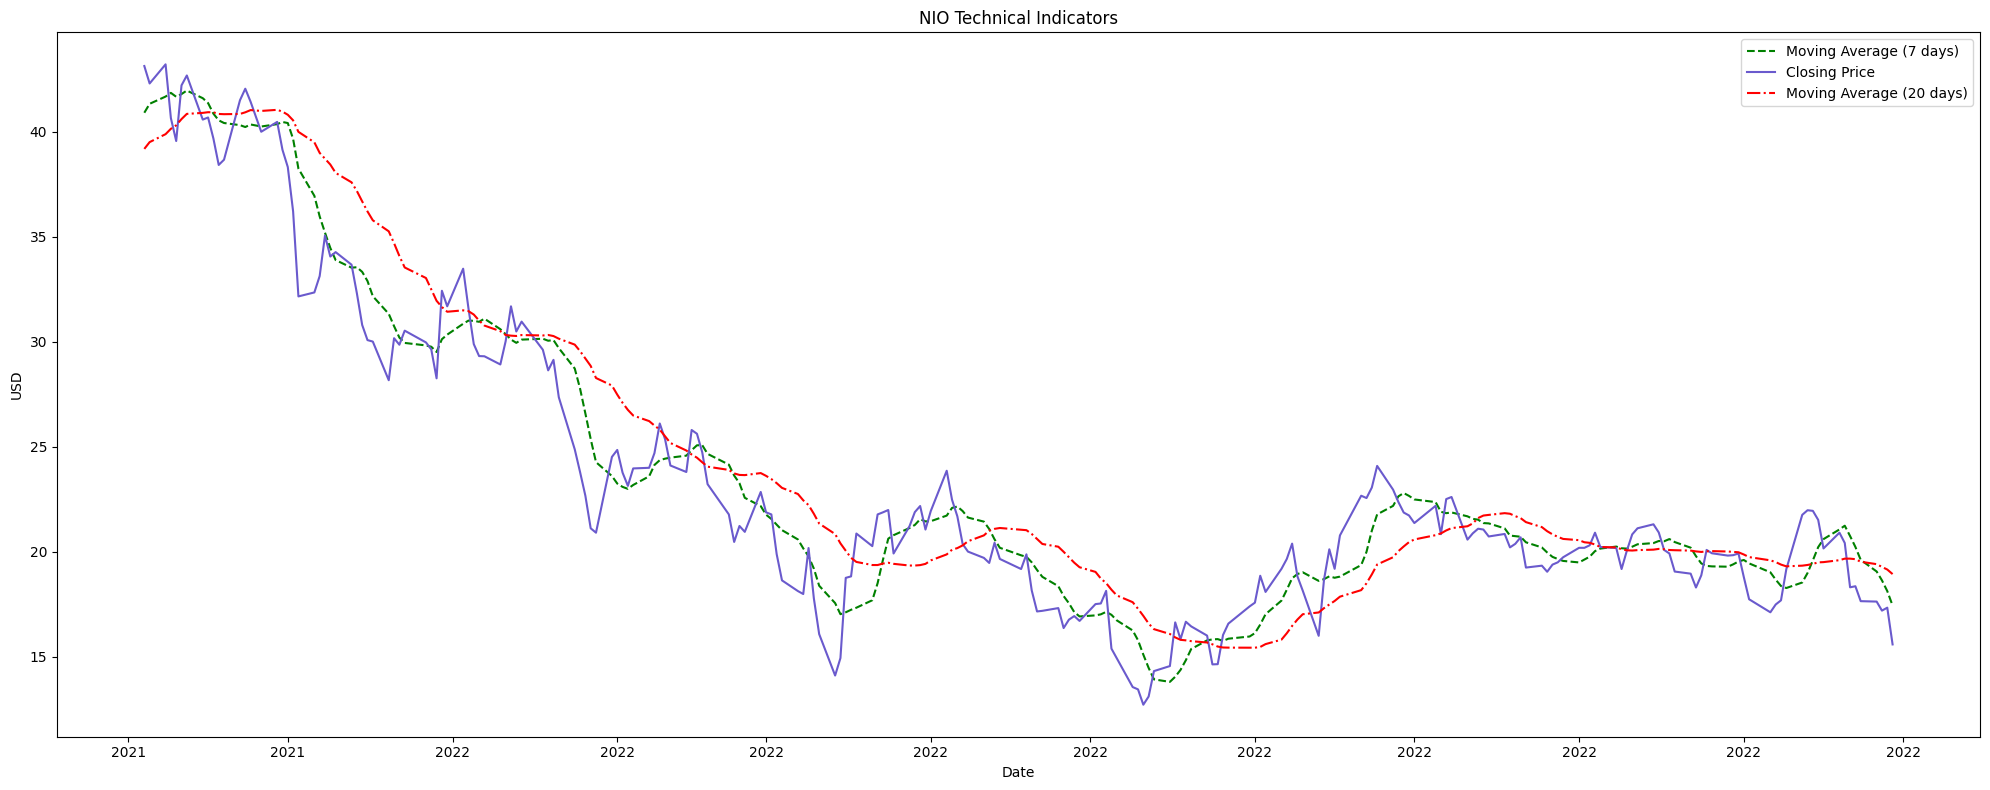

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_82 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_83 (LSTM)              (None, 32)                12416     
                                                                 
 dense_54 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

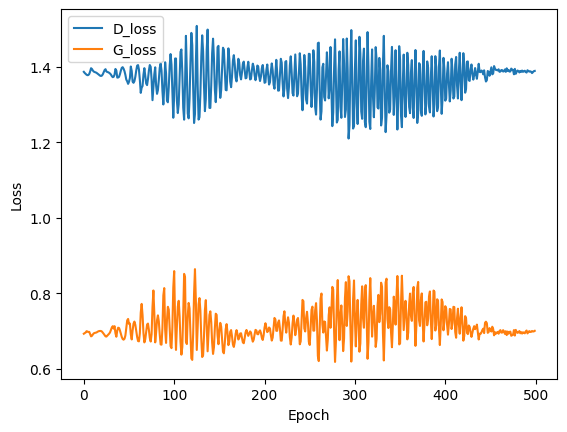

Training RMSE 0.06140538927916305


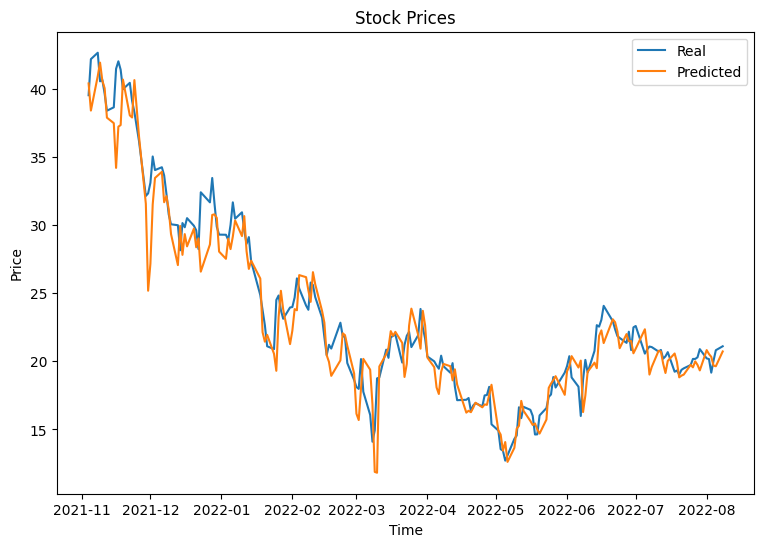

Test RMSE 1.1891368209870146


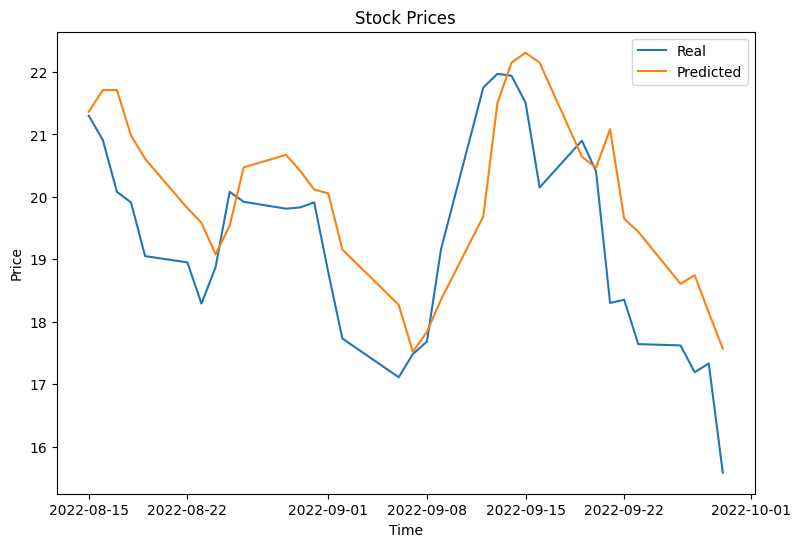

In [ ]:
parameters = [1e-3, 500]
X, y, date = clean_data(all_tweets, all_stocks, 'NIO')
X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days_to_consider, days_to_predict)

gen_model = make_generator_model(days_to_consider, X_train.shape[2], days_to_predict)
print(gen_model.summary())

disc_model = make_discriminator_model(days_to_predict, days_to_consider)
print(disc_model.summary())

dir_path = '/content/models_gan'

if os.path.exists(dir_path):
  shutil.rmtree(dir_path)
else:
  print(f"Directory '{dir_path}' does not exist.")

gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss)
Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan)
print('Training RMSE', RMSE)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[:X_train.shape[0]], rescaled_Real_price, label='Real')
ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()


gen_model_best = tf.keras.models.load_model('/content/models_gan/generator_V_499.h5')
#gen_model_best.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3,  beta_1=0.5), loss = tf.keras.losses.BinaryCrossentropy())

y_test_predicted = gen_model_best(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print('Test RMSE', Test_RMSE)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()

## Stock Prediction for 'META'

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


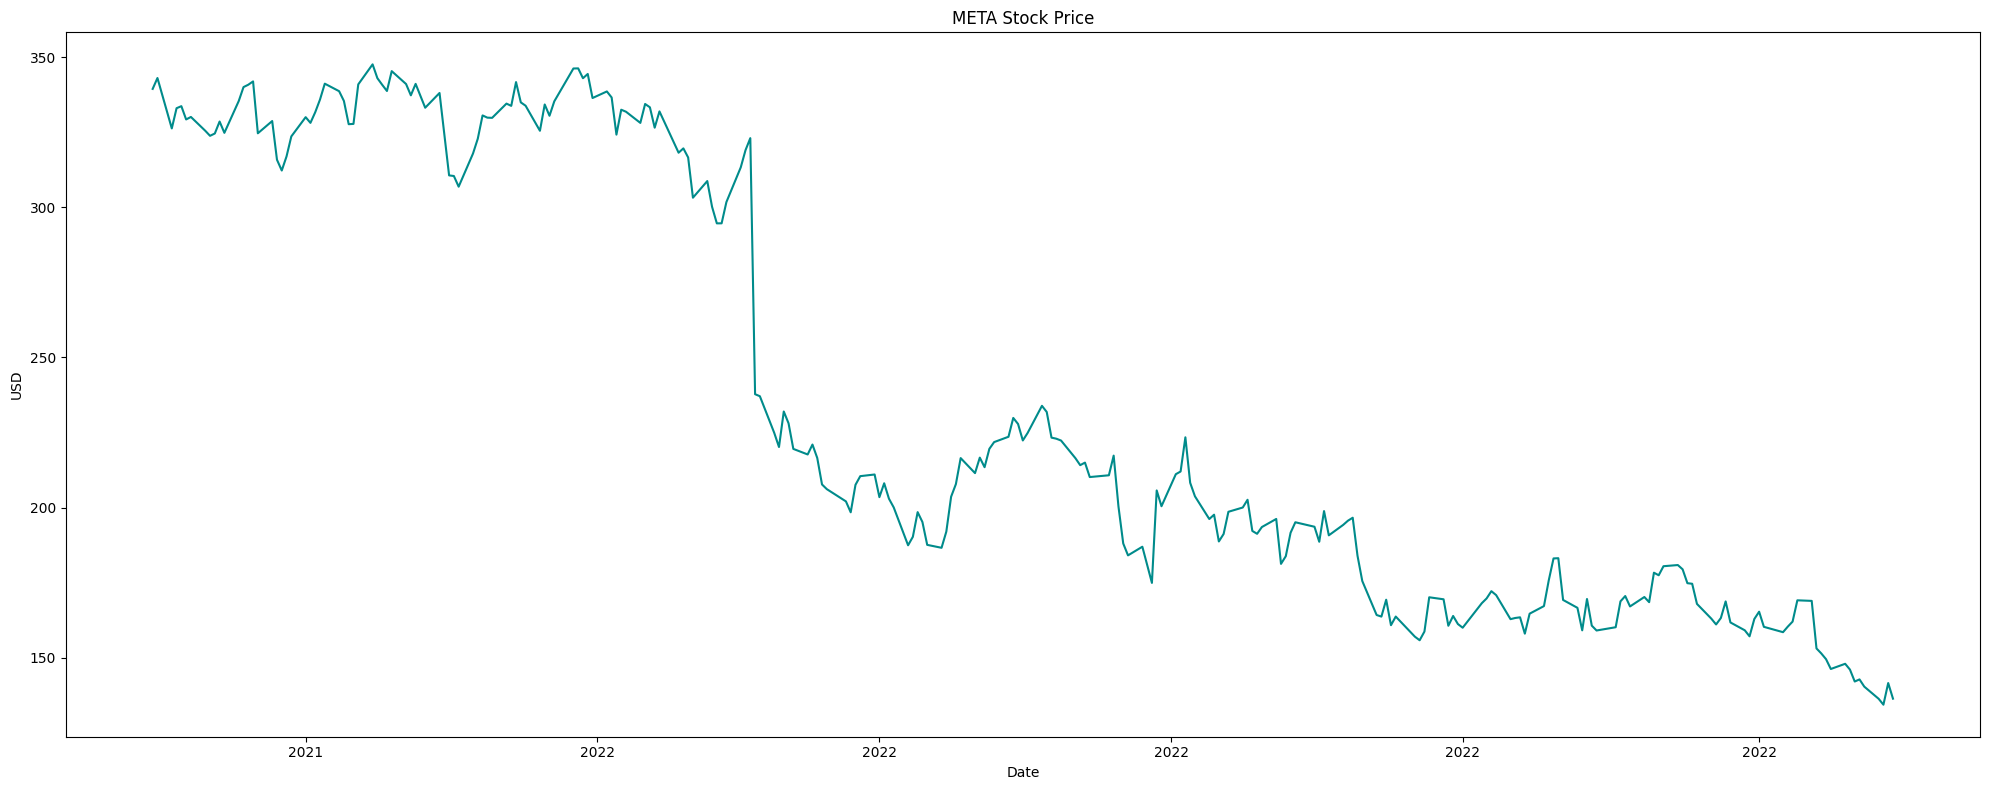

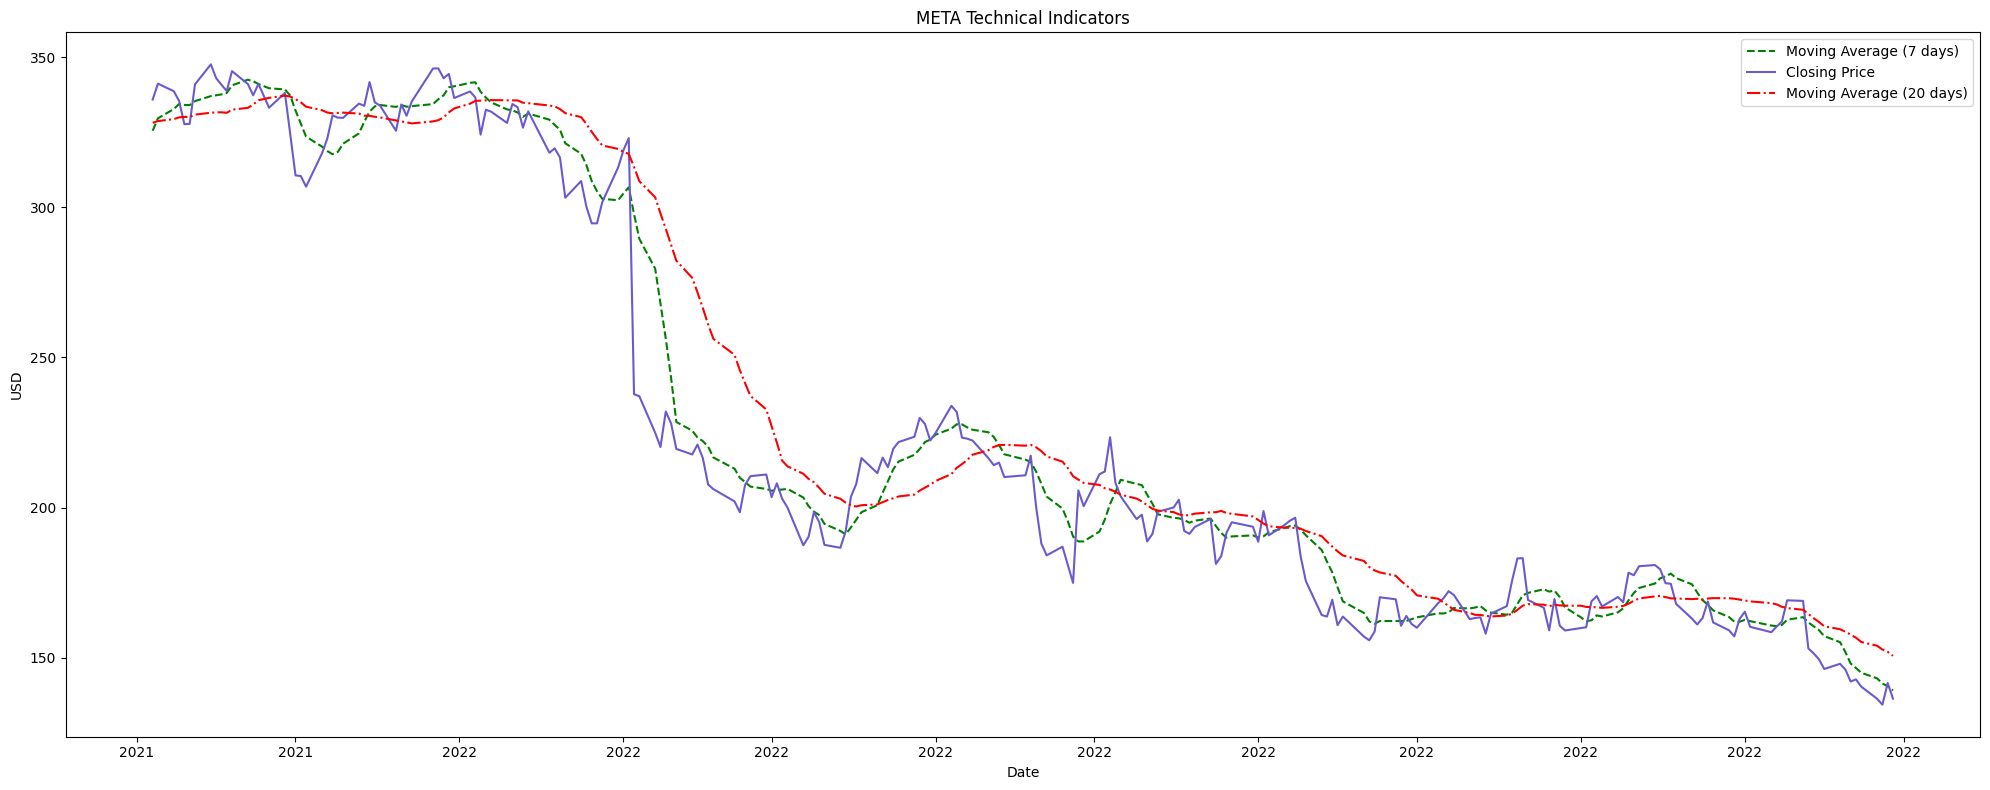

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_102 (LSTM)             (None, 4, 128)            72704     
                                                                 
 lstm_103 (LSTM)             (None, 4, 64)             49408     
                                                                 
 lstm_104 (LSTM)             (None, 32)                12416     
                                                                 
 dense_68 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

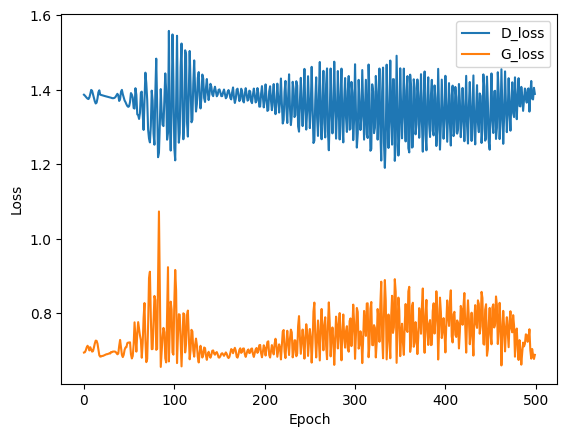

Training RMSE 0.06549997575405991


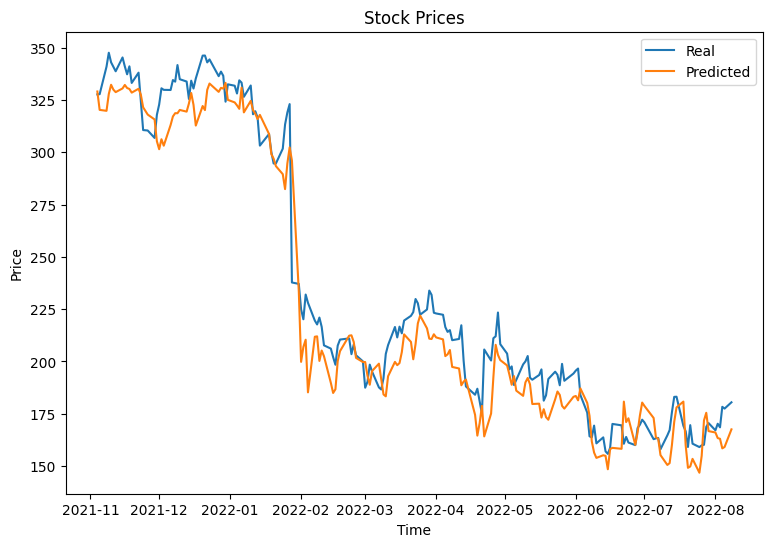

Test RMSE 8.769069551090599


In [ ]:
parameters = [1e-3, 500]
X, y, date = clean_data(all_tweets, all_stocks, 'META')
X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days_to_consider, days_to_predict)

gen_model = make_generator_model(days_to_consider, X_train.shape[2], days_to_predict)
print(gen_model.summary())

disc_model = make_discriminator_model(days_to_predict, days_to_consider)
print(disc_model.summary())

dir_path = '/content/models_gan'

if os.path.exists(dir_path):
  shutil.rmtree(dir_path)
else:
  print(f"Directory '{dir_path}' does not exist.")

gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss)
Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan)
print('Training RMSE', RMSE)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[:X_train.shape[0]], rescaled_Real_price, label='Real')
ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()


gen_model_best = tf.keras.models.load_model('/content/models_gan/generator_V_499.h5')
#gen_model_best.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3,  beta_1=0.5), loss = tf.keras.losses.BinaryCrossentropy())

y_test_predicted = gen_model_best(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print('Test RMSE', Test_RMSE)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()

## Stock Prediction for 'AMD'

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


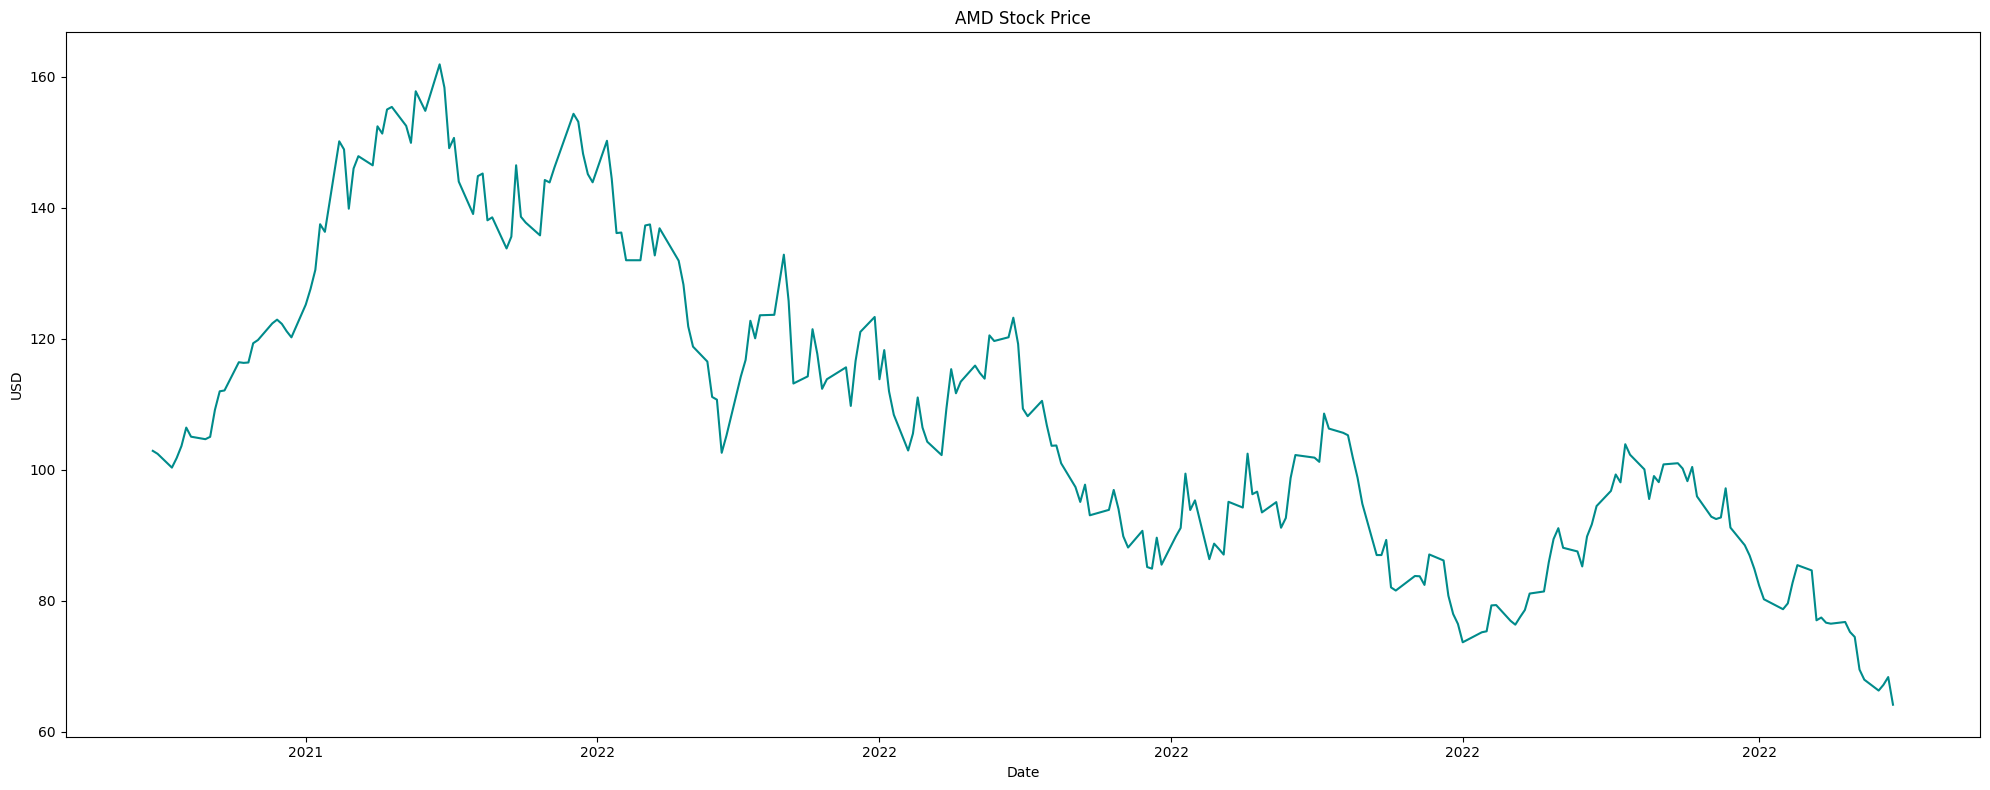

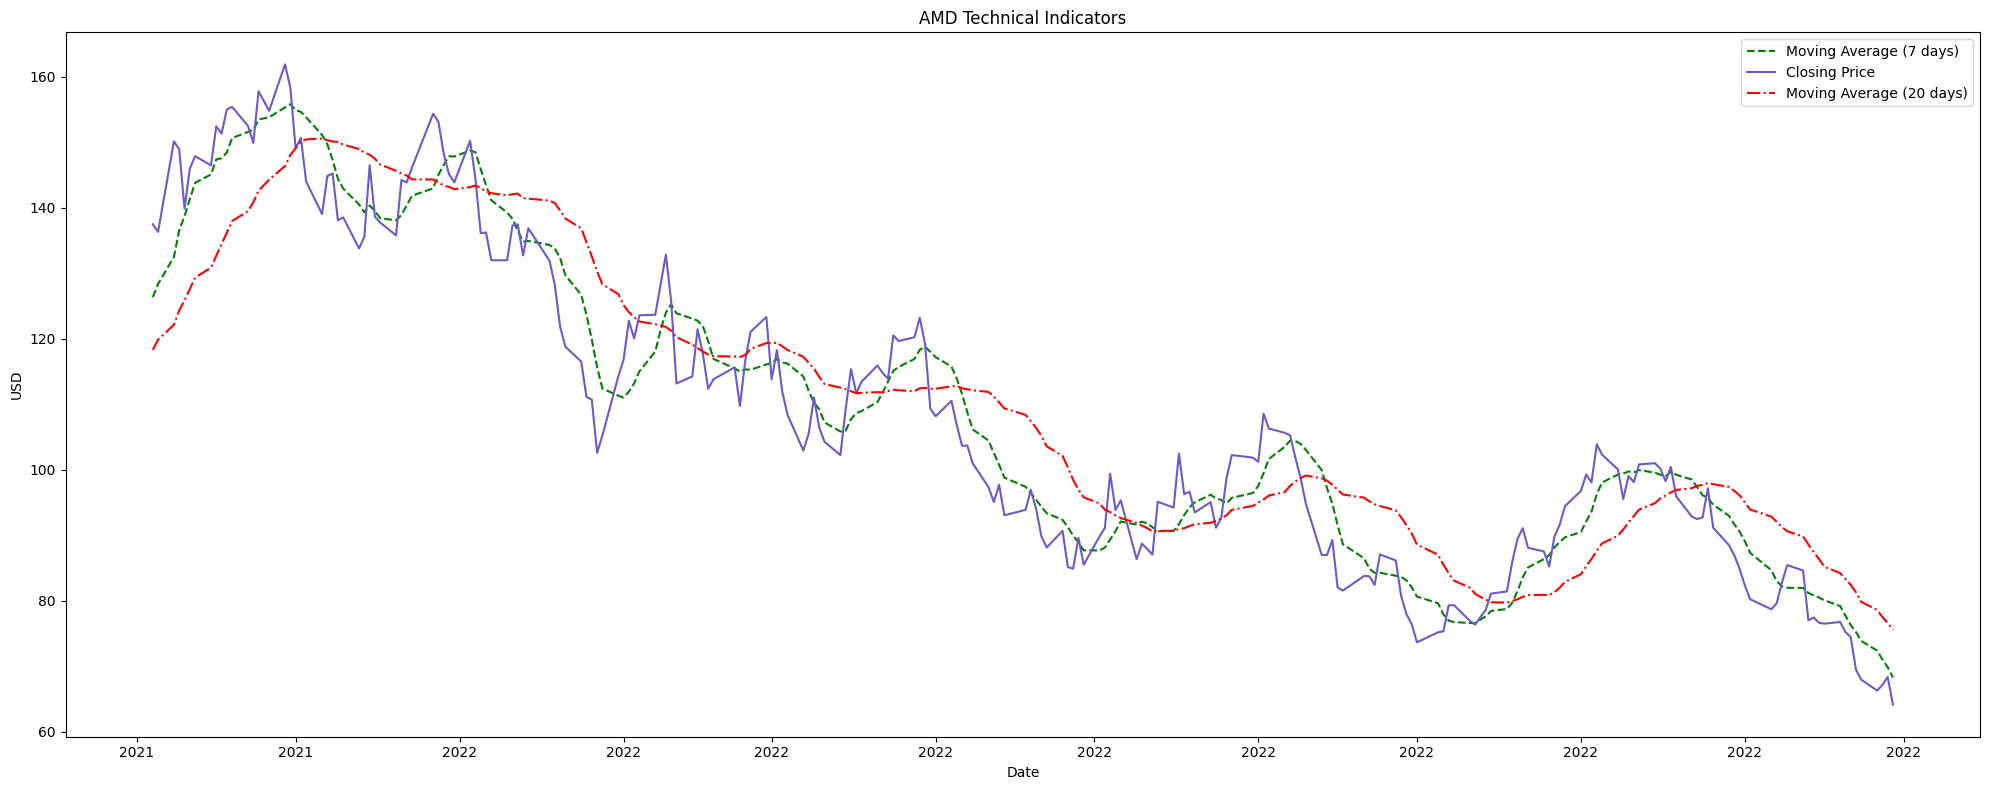

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_99 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_100 (LSTM)             (None, 4, 64)             49408     
                                                                 
 lstm_101 (LSTM)             (None, 32)                12416     
                                                                 
 dense_66 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

Training RMSE 0.06304340694612062


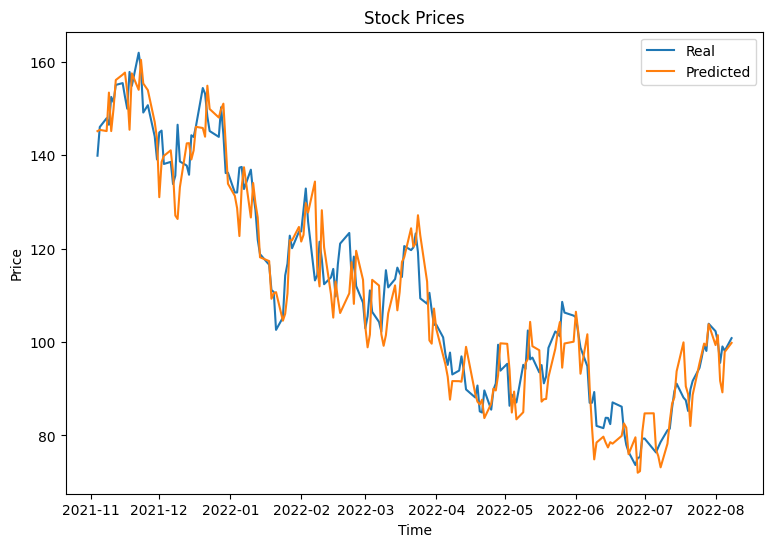

Test RMSE 4.194458693287813


In [ ]:
parameters = [1e-3, 500]
X, y, date = clean_data(all_tweets, all_stocks, 'AMD')
X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days_to_consider, days_to_predict)

gen_model = make_generator_model(days_to_consider, X_train.shape[2], days_to_predict)
print(gen_model.summary())

disc_model = make_discriminator_model(days_to_predict, days_to_consider)
print(disc_model.summary())

dir_path = '/content/models_gan'

if os.path.exists(dir_path):
  shutil.rmtree(dir_path)
else:
  print(f"Directory '{dir_path}' does not exist.")

gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss)
Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan)
print('Training RMSE', RMSE)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[:X_train.shape[0]], rescaled_Real_price, label='Real')
ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()


gen_model_best = tf.keras.models.load_model('/content/models_gan/generator_V_499.h5')
#gen_model_best.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3,  beta_1=0.5), loss = tf.keras.losses.BinaryCrossentropy())

y_test_predicted = gen_model_best(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print('Test RMSE', Test_RMSE)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()

## Stock Prediction for 'NFLX'

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


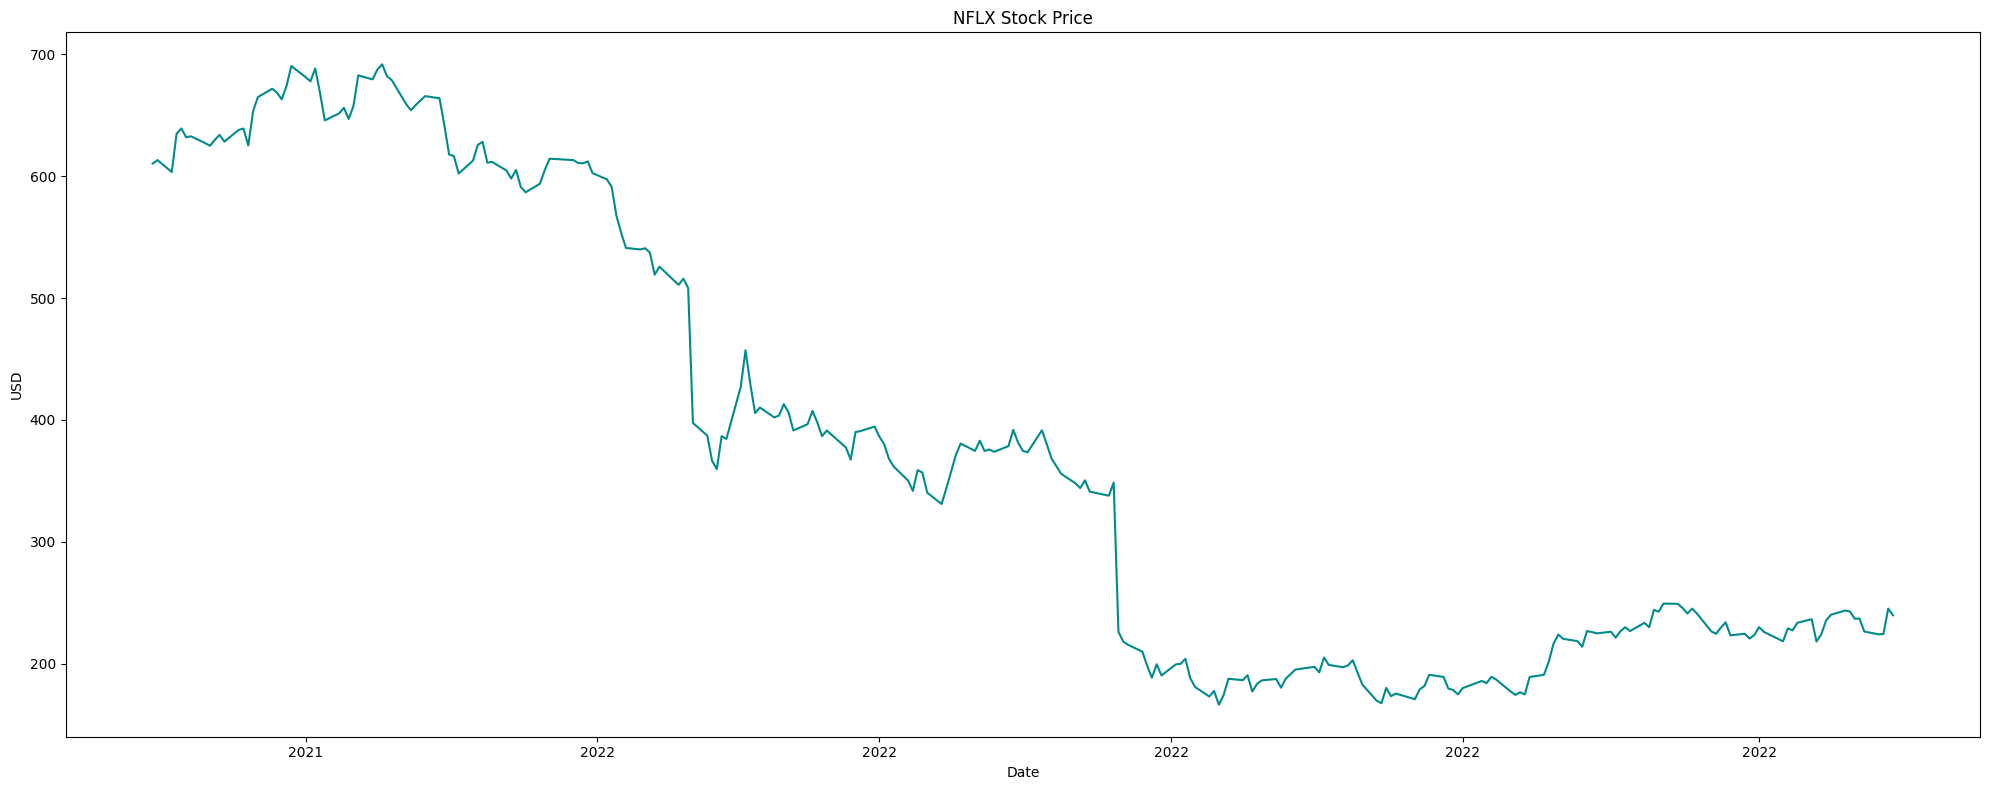

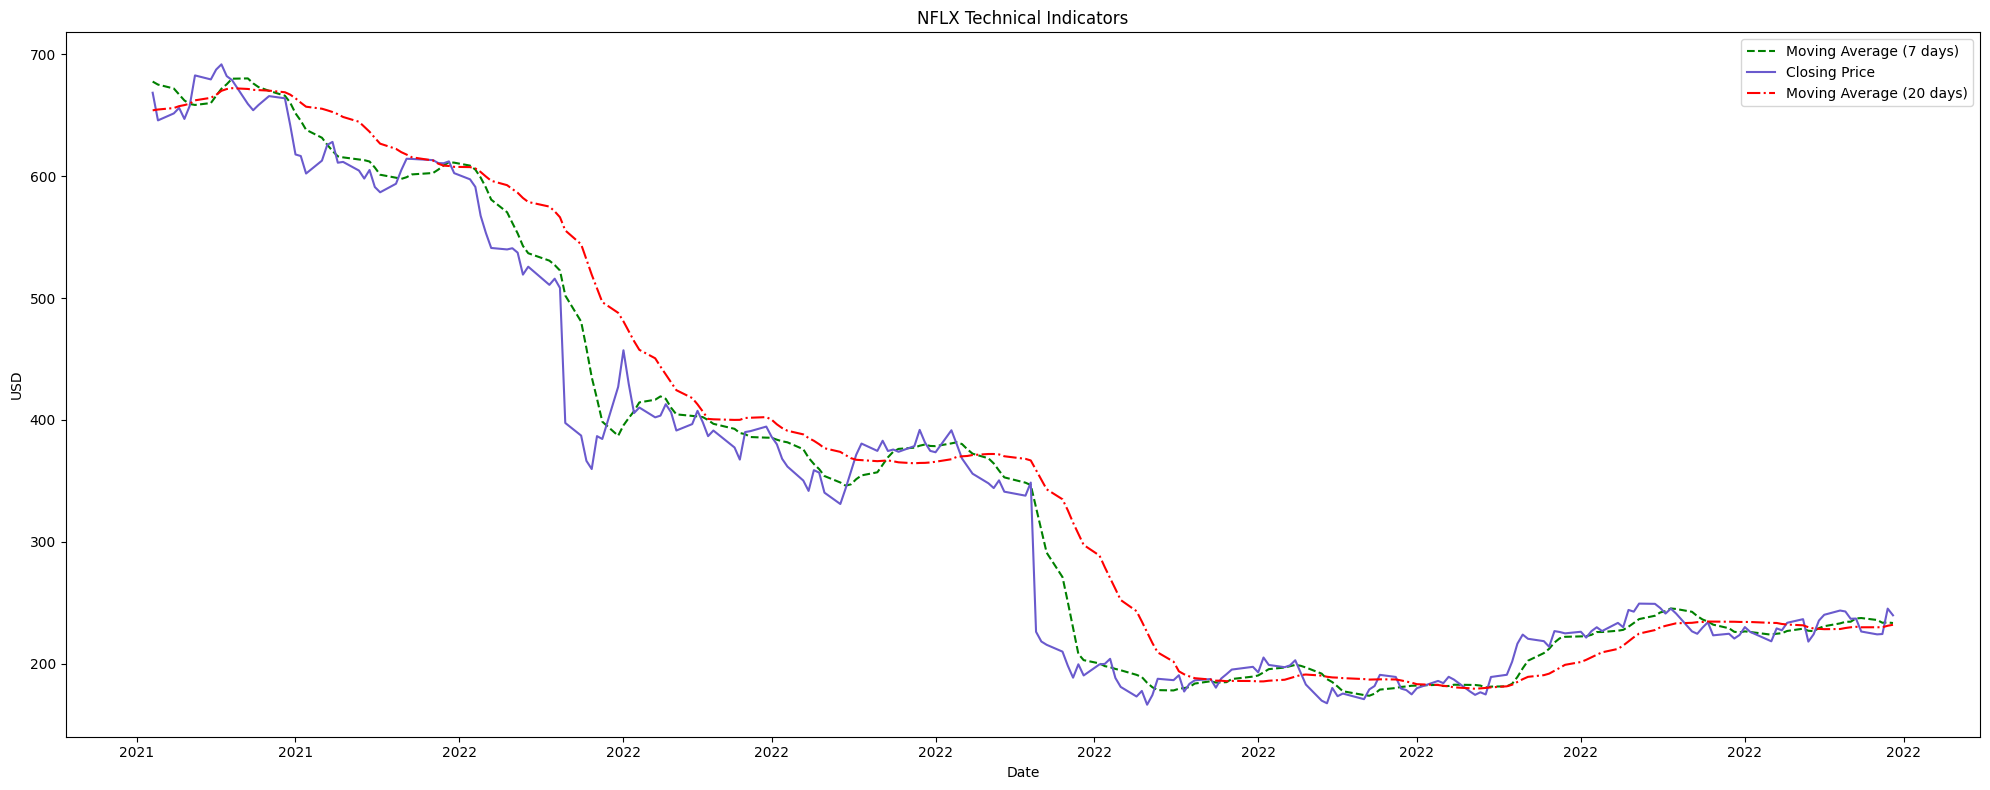

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_97 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_98 (LSTM)              (None, 32)                12416     
                                                                 
 dense_64 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

Training RMSE 0.045881528971691836


Test RMSE 9.5635802757216


In [ ]:
parameters = [1e-3, 500]
X, y, date = clean_data(all_tweets, all_stocks, 'NFLX')
X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days_to_consider, days_to_predict)

gen_model = make_generator_model(days_to_consider, X_train.shape[2], days_to_predict)
print(gen_model.summary())

disc_model = make_discriminator_model(days_to_predict, days_to_consider)
print(disc_model.summary())

dir_path = '/content/models_gan'

if os.path.exists(dir_path):
  shutil.rmtree(dir_path)
else:
  print(f"Directory '{dir_path}' does not exist.")

gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss)
Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan)
print('Training RMSE', RMSE)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[:X_train.shape[0]], rescaled_Real_price, label='Real')
ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()


gen_model_best = tf.keras.models.load_model('/content/models_gan/generator_V_499.h5')
#gen_model_best.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3,  beta_1=0.5), loss = tf.keras.losses.BinaryCrossentropy())

y_test_predicted = gen_model_best(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print('Test RMSE', Test_RMSE)

fig, ax = plt.subplots(figsize=(9,6))
# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')
# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# Add a title to the plot
ax.set_title('Stock Prices')
# Add a legend to the plot
ax.legend()
# Show the plot
plt.show()